In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from models_evaluate import *

SEED = 42
np.random.seed(SEED)
random.seed(SEED)


Ноутбук представляет базовый пайплайн для задачи бинарной классификации твитов: определяем, описывают ли они реальные катастрофы (target=1) или нет (target=0). Данные взяты из Kaggle Disaster Tweets (https://www.kaggle.com/c/nlp-getting-started).

## 1. Загрузка и предобработка данных

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Выполним обработку пропусков: заполним NaN в keyword, добавим флаг has_location, конкатенируем text + keyword

In [3]:
df['keyword'].fillna('', inplace=True)
df['has_location'] = df['location'].notna().astype(int)
df.drop('location', axis=1, inplace=True)
df['full_text'] = df['text'] + ' ' + df['keyword']

C:\Users\luckydiss\AppData\Local\Temp\ipykernel_14356\1725234625.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['keyword'].fillna('', inplace=True)


Разделяем на признаки и целевую переменную


In [4]:
X, y = df['full_text'], df['target']


Определим ряд базовых моделей:

In [5]:
models = [
    ('DummyClassifier', DummyClassifier(random_state=SEED, strategy='most_frequent')),
    ('LogisticRegression', LogisticRegression(random_state=SEED, max_iter=1000, solver='liblinear')),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=SEED, max_depth=4)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=SEED)),
    ('LGBMClassifier', LGBMClassifier(random_state=SEED, verbose=-1))
]

Инициализируем 5-fold стратифицированную CV

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

print(f"\nModels to evaluate: {len(models)}")
print(f"Cross-validation folds: {cv.n_splits}")


Models to evaluate: 5
Cross-validation folds: 5


## 3. Базовый CountVectorizer (биграммы, min_df=2)

CountVectorizer строит разреженную матрицу частот n-грамм.
Каждый уникальный токен представляется отдельным признаком, значение которого = количество вхождений.

ngram_range = (1,2) используем униграммы+биграммы чтобы захватить такие словосочетания как forest fire, nuclear disaster и т.п.

min_df=2 (минимум 2 документа) и max_df=0.9 (максимум 90% документов) - отсекаем редкие токены и опечатки а также убираем сверхчастотные токены (http, co, amp)

In [7]:
# Создаем пайплайн с CountVectorizer
count_vectorizer_preprocessor = Pipeline([
    ('vectorizer', CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        dtype=np.float32
    ))
])


In [8]:
count_vectorizer_results, cv_pipelines = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_preprocessor,
    cv=cv,
    seed=SEED
)

                    model   roc_auc  f1_score  precision    recall  accuracy  \
0         DummyClassifier  0.500000  0.363195   0.285170  0.500000  0.570340   
1      LogisticRegression  0.856752  0.791906   0.799615  0.788375  0.799290   
2  DecisionTreeClassifier  0.679137  0.602269   0.672144  0.618262  0.648627   
3  RandomForestClassifier  0.837420  0.761289   0.796848  0.755736  0.778405   
4          LGBMClassifier  0.848422  0.779512   0.791918  0.775135  0.789046   

   training_time  
0       2.398436  
1       1.901946  
2       2.022406  
3      32.410762  
4       3.517512  


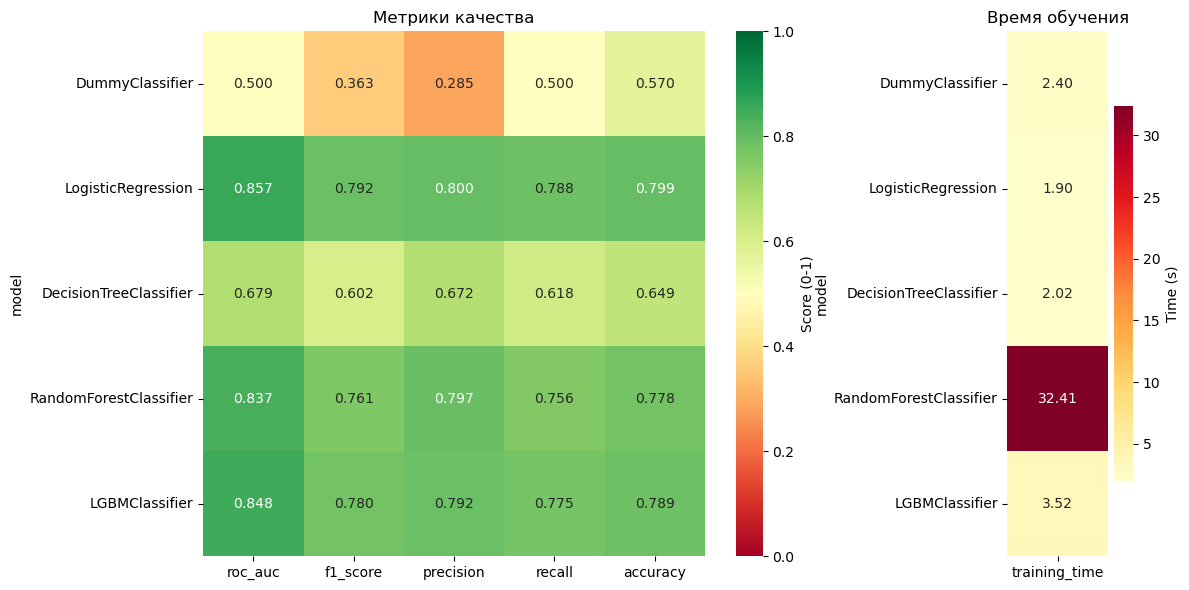

,model,roc_auc,f1_score,precision,recall,accuracy,training_time
0,DummyClassifier,0.500000,0.363195,0.285170,0.500000,0.570340,2.398436
1,LogisticRegression,0.856752,0.791906,0.799615,0.788375,0.799290,1.901946
2,DecisionTreeClassifier,0.679137,0.602269,0.672144,0.618262,0.648627,2.022406
3,RandomForestClassifier,0.837420,0.761289,0.796848,0.755736,0.778405,32.410762
4,LGBMClassifier,0.848422,0.779512,0.791918,0.775135,0.789046,3.517512


In [9]:
compare_models_metrics(count_vectorizer_results)

По f1 score логистическая регрессия показала наилучший результат (0.792), бустинг и ансамбль деревьев чуть хуже (0.78 и 0.76)

[DummyClassifier] does not support feature importance



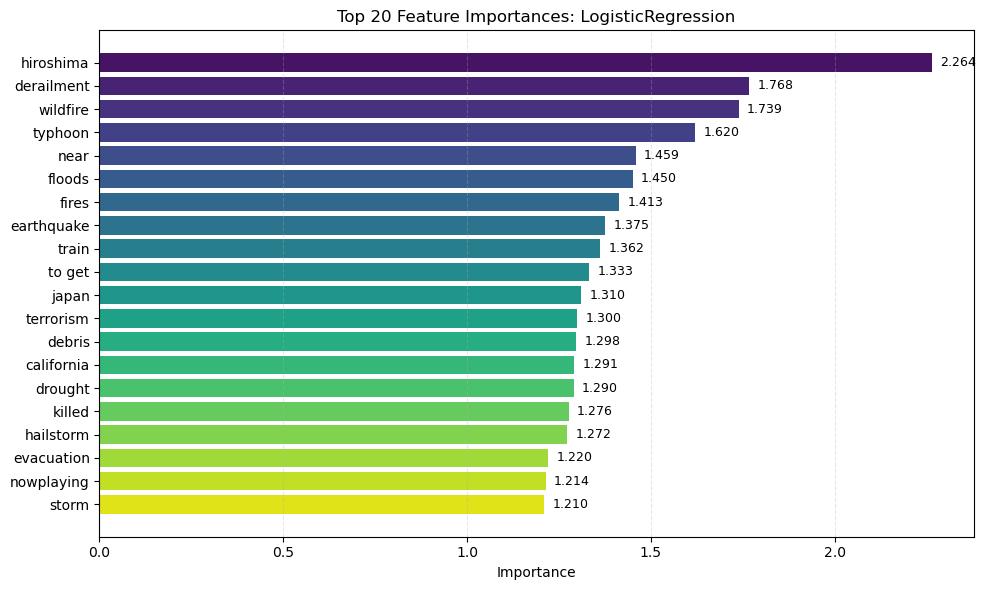

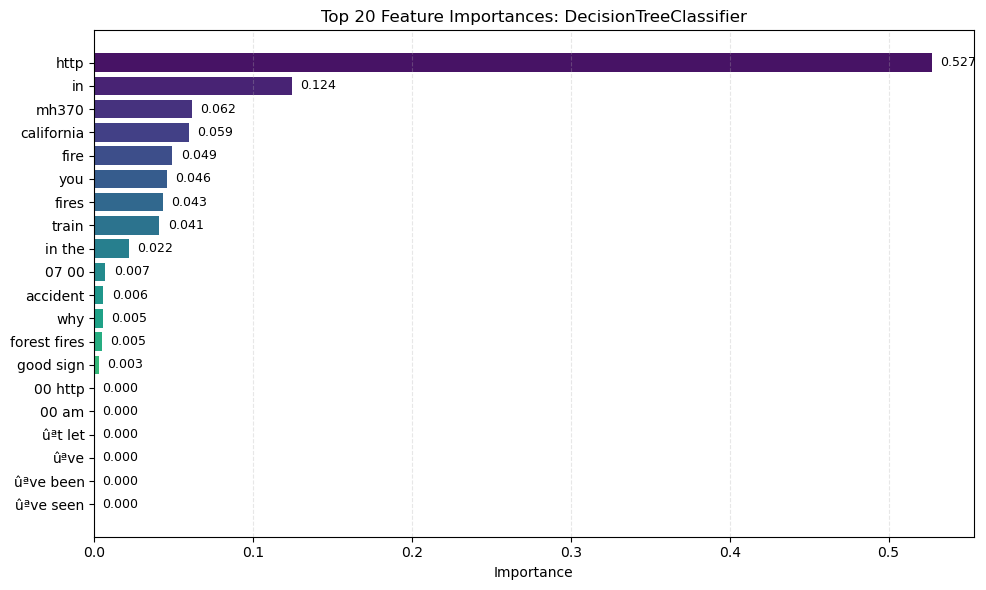

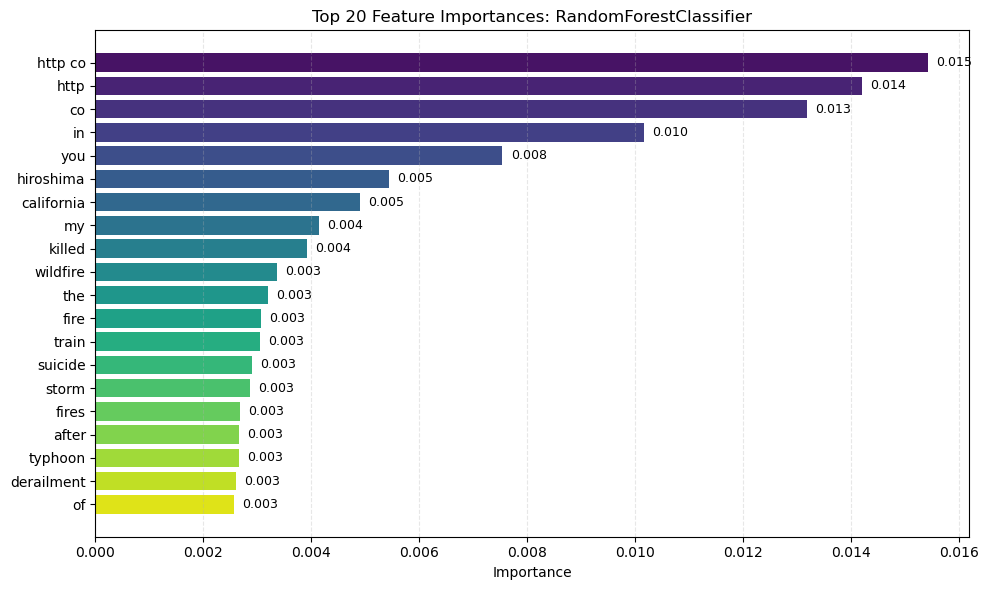

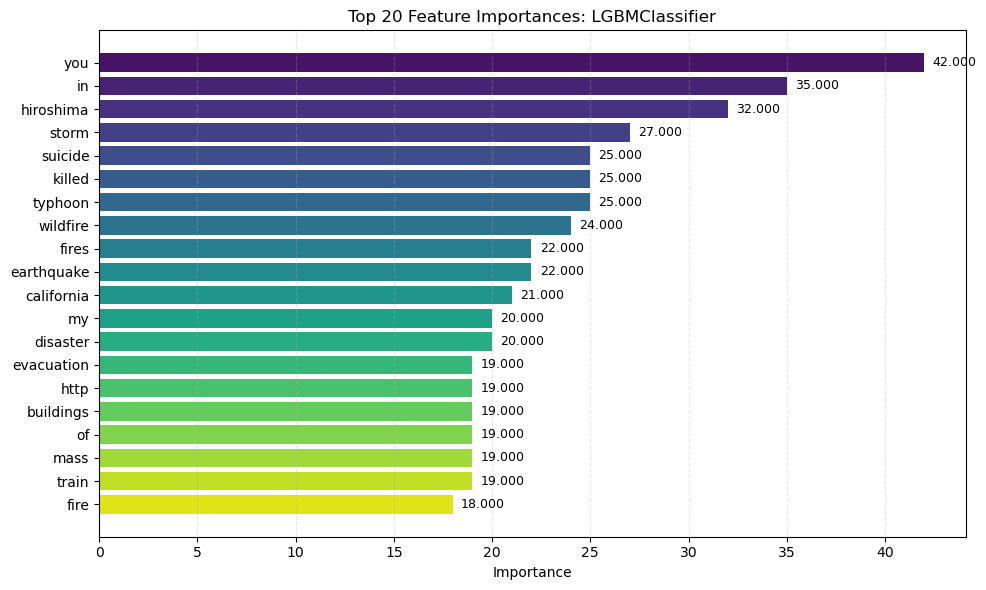

In [10]:
plot_feature_importance_for_models(cv_pipelines, top_n=20)

Logistic Regression фокусируется на реальных маркерах катастроф (hiroshima, wildfire, earthquake, typhoon), 

Decision Tree переоценивает один сильный признак (http),

Random Forest распределяет важность между несколькими словами, включая как disaster-термины, так и артефакты CountVectorizer (http, co), 

LGBM учитывает частоту и взаимодействия, из-за чего стоп-слова (you, in) тоже оказываются среди топ-значимых. 

Таким образом, на первый взгляд, кажется, что влияние стоп-слов и ссылок искажает интерпретацию, поэтому для более корректного анализа попробуем удалить стоп-слова

### 4. CountVectorizer + удаление стоп-слов 

In [11]:
count_vectorizer_no_stop_preprocessor = Pipeline([
    ('vectorizer', CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        stop_words='english',
        dtype=np.float32
    ))
])

                    model   roc_auc  f1_score  precision    recall  accuracy  \
0         DummyClassifier  0.500000  0.363195   0.285170  0.500000  0.570340   
1      LogisticRegression  0.854852  0.790946   0.800159  0.787013  0.798897   
2  DecisionTreeClassifier  0.657027  0.644542   0.644621  0.647121  0.647841   
3  RandomForestClassifier  0.834734  0.763430   0.787745  0.758212  0.777486   
4          LGBMClassifier  0.841576  0.768468   0.783777  0.763941  0.779589   

   training_time  
0       0.563941  
1       0.659726  
2       0.708094  
3      25.863107  
4       2.557068  


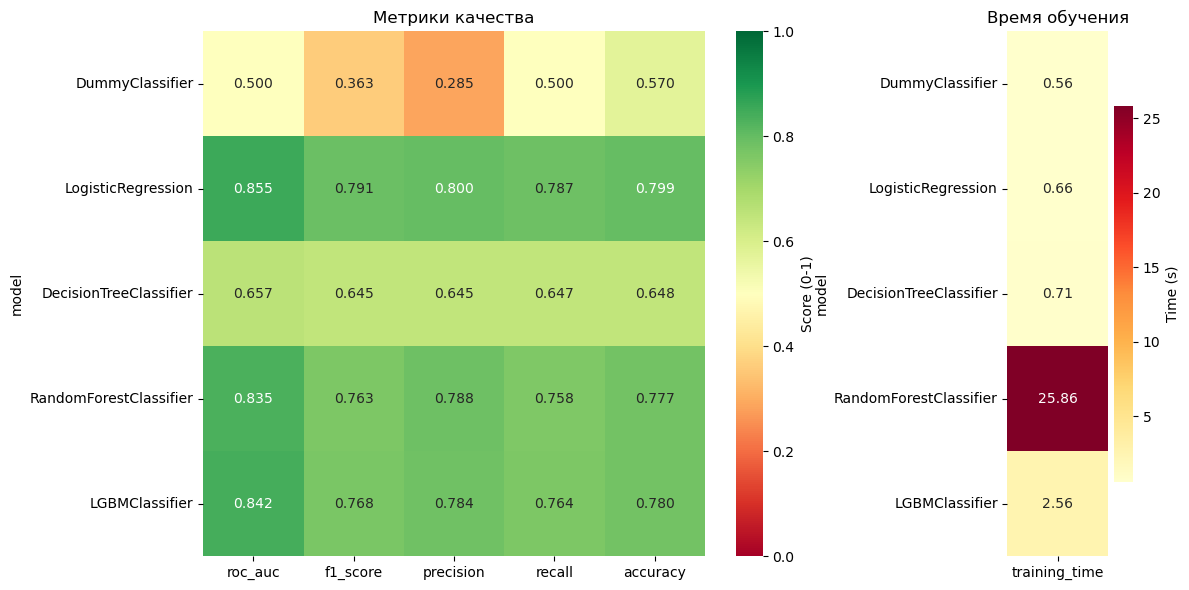

,model,roc_auc,f1_score,precision,recall,accuracy,training_time
0,DummyClassifier,0.500000,0.363195,0.285170,0.500000,0.570340,0.563941
1,LogisticRegression,0.854852,0.790946,0.800159,0.787013,0.798897,0.659726
2,DecisionTreeClassifier,0.657027,0.644542,0.644621,0.647121,0.647841,0.708094
3,RandomForestClassifier,0.834734,0.763430,0.787745,0.758212,0.777486,25.863107
4,LGBMClassifier,0.841576,0.768468,0.783777,0.763941,0.779589,2.557068


In [12]:
cv_results_no_stop, cv_pipelines_no_stop = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_no_stop_preprocessor,
    cv=cv,
    seed=SEED
)

compare_models_metrics(cv_results_no_stop)

In [13]:
cv_pipelines_no_stop

{'DummyClassifier': Pipeline(steps=[('vectorizer',
                  CountVectorizer(dtype=<class 'numpy.float32'>, max_df=0.9,
                                  min_df=2, ngram_range=(1, 2),
                                  stop_words='english')),
                 ('classifier',
                  DummyClassifier(random_state=42, strategy='most_frequent'))]),
 'LogisticRegression': Pipeline(steps=[('vectorizer',
                  CountVectorizer(dtype=<class 'numpy.float32'>, max_df=0.9,
                                  min_df=2, ngram_range=(1, 2),
                                  stop_words='english')),
                 ('classifier',
                  LogisticRegression(max_iter=1000, random_state=42,
                                     solver='liblinear'))]),
 'DecisionTreeClassifier': Pipeline(steps=[('vectorizer',
                  CountVectorizer(dtype=<class 'numpy.float32'>, max_df=0.9,
                                  min_df=2, ngram_range=(1, 2),
                       

[DummyClassifier] does not support feature importance



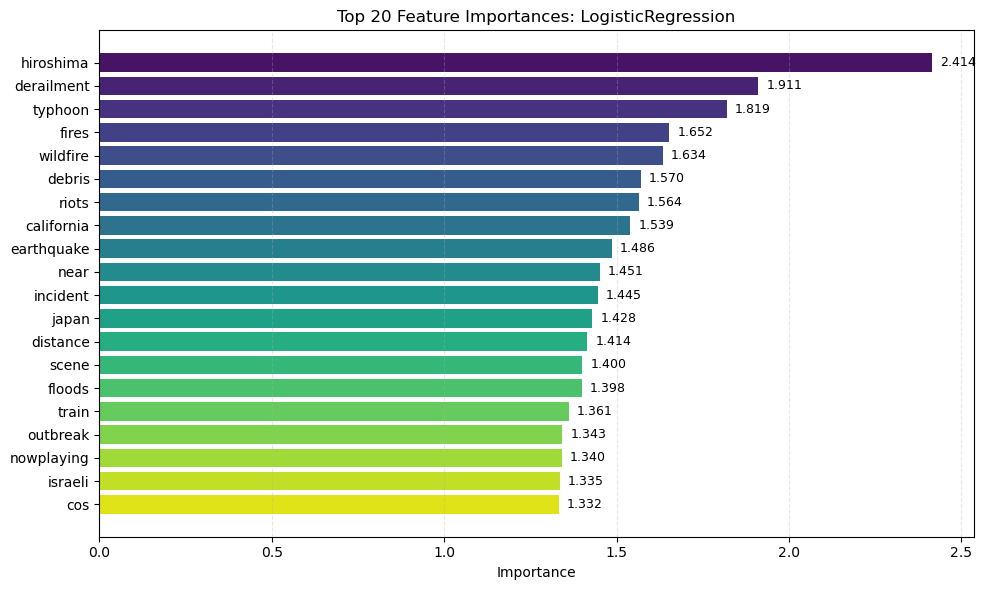

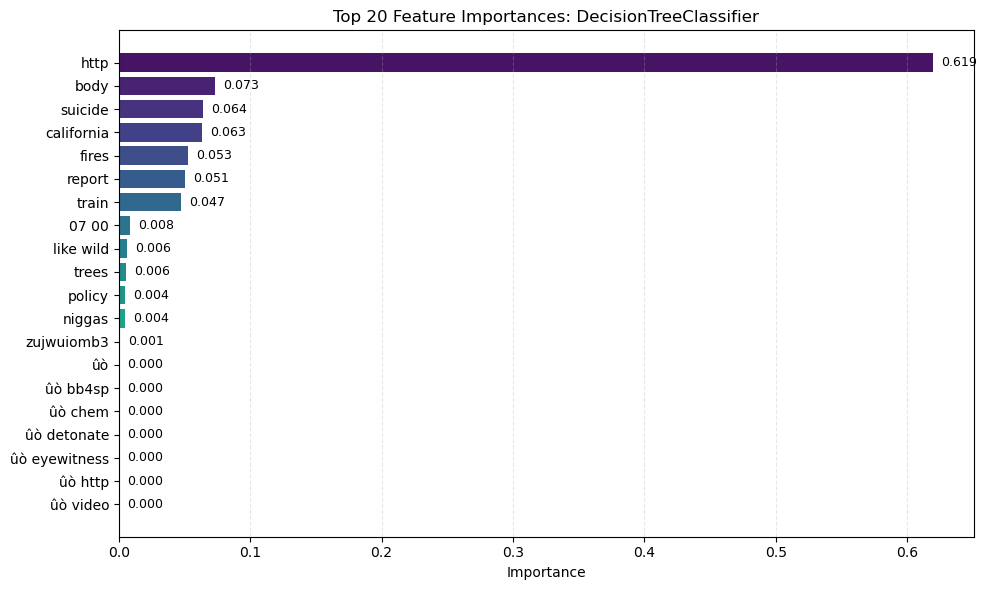

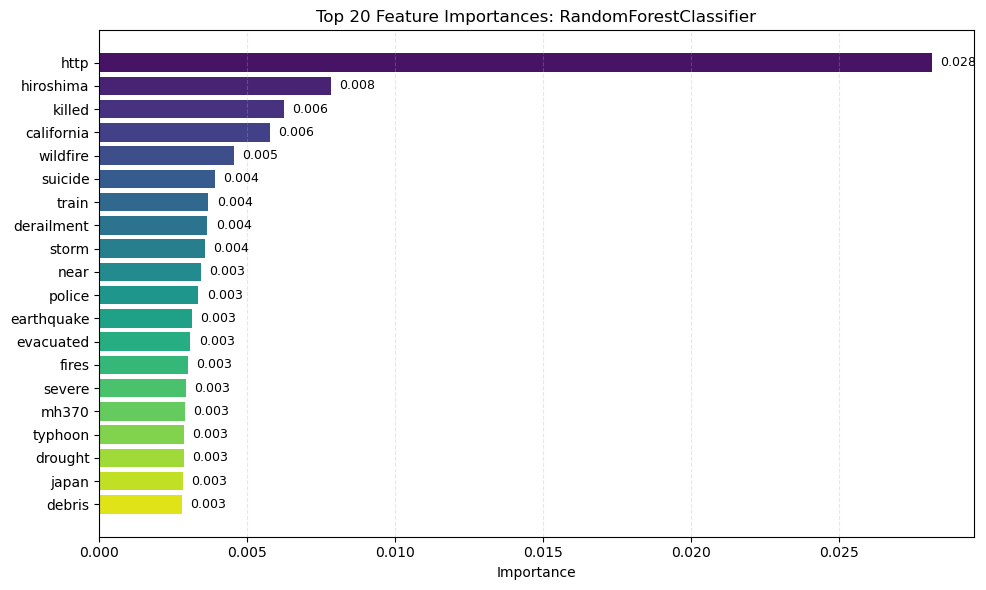

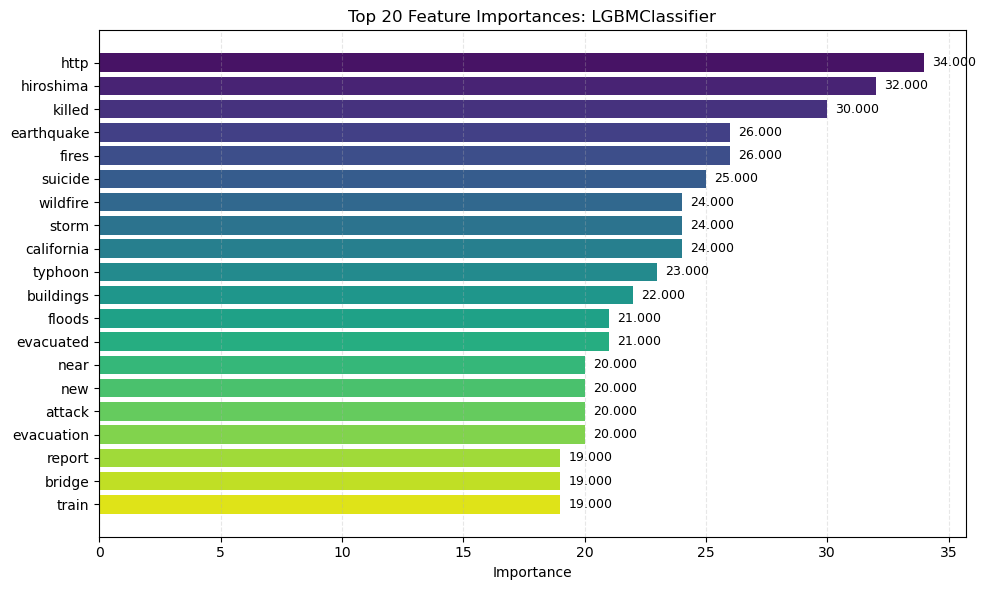

In [14]:
plot_feature_importance_for_models(cv_pipelines_no_stop, top_n=20)

Теперь модели на акцентируют внимание на стоп словах, однако бустинг, лес и дерево решений принимают за самый важный признак http (какая либо ссылка). Для исключения таких слов, необходимо проделать более глубокую очистку, характерную для сообщений в твитах

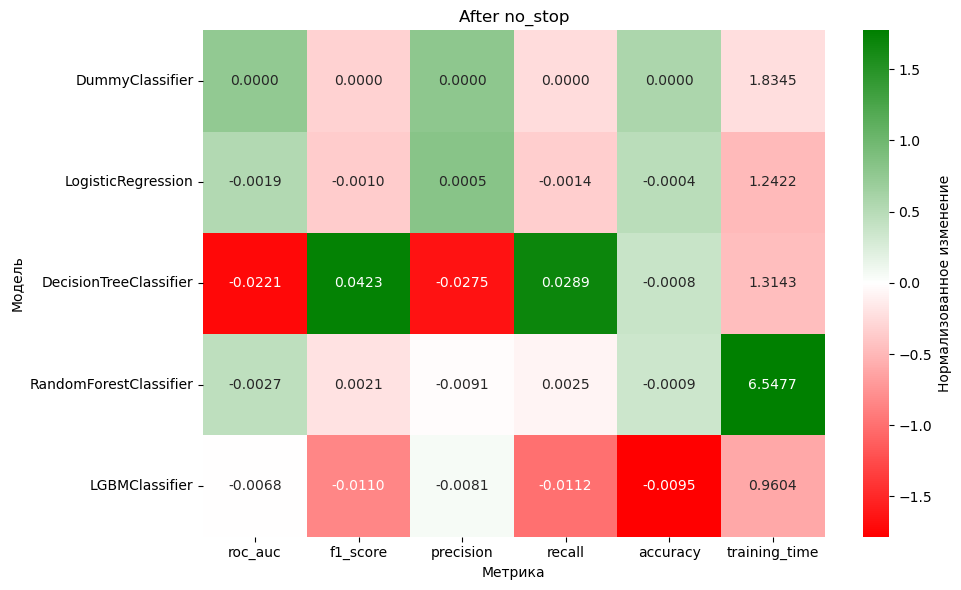

In [15]:
# Сравниваем улучшения
diff_df = compare_models_improvement(
    new_results=cv_results_no_stop,
    base_results=count_vectorizer_results,
    title='After no_stop',
    metrics_to_compare=['roc_auc', 'f1_score', 'precision', 'recall', 'accuracy', 'training_time']
)

По метрикам результаты не улучшились

### 4. CountVectorizer + очистка текста + стоп слова

Приведем слова к нижнему регистру, удалим: ссылки (http, www, https), упоминания пользователей (@) и решетки (#)

In [16]:
import re
import nltk

def clean_tweet_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text) 
    return text.strip()

df['text_deep_cleaned'] = df['full_text'].apply(clean_tweet_text)

X_text_deep_cleaned = df['text_deep_cleaned']

In [17]:
df

,id,keyword,text,target,has_location,full_text,text_deep_cleaned
0,1,,Our Deeds are the Reason of this #earthquake M...,1,0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...
1,4,,Forest fire near La Ronge Sask. Canada,1,0,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada
2,5,,All residents asked to 'shelter in place' are ...,1,0,All residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,6,,"13,000 people receive #wildfires evacuation or...",1,0,"13,000 people receive #wildfires evacuation or...","13,000 people receive wildfires evacuation ord..."
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,0,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...,...
7608,10869,,Two giant cranes holding a bridge collapse int...,1,0,Two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...
7609,10870,,@aria_ahrary @TheTawniest The out of control w...,1,0,@aria_ahrary @TheTawniest The out of control w...,the out of control wild fires in california ev...
7610,10871,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,0,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m1.94 [01:04 utc]?5km s of volcano hawaii.
7611,10872,,Police investigating after an e-bike collided ...,1,0,Police investigating after an e-bike collided ...,police investigating after an e-bike collided ...


In [18]:
X, y = df['text_deep_cleaned'], df['target']

                    model   roc_auc  f1_score  precision    recall  accuracy  \
0         DummyClassifier  0.500000  0.363195   0.285170  0.500000  0.570340   
1      LogisticRegression  0.850924  0.789945   0.799335  0.786020  0.797978   
2  DecisionTreeClassifier  0.553807  0.473854   0.779408  0.554106  0.616315   
3  RandomForestClassifier  0.832370  0.768394   0.783363  0.763902  0.779326   
4          LGBMClassifier  0.838888  0.767392   0.780380  0.763199  0.777750   

   training_time  
0       0.455225  
1       0.455922  
2       0.550519  
3      27.938937  
4       2.342047  


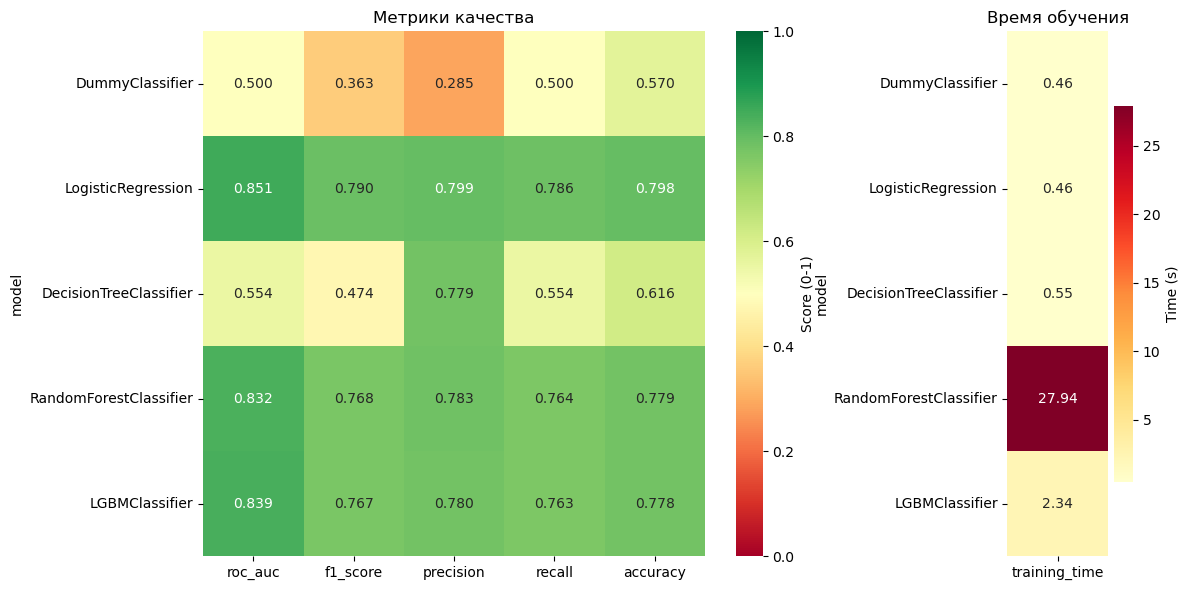

,model,roc_auc,f1_score,precision,recall,accuracy,training_time
0,DummyClassifier,0.500000,0.363195,0.285170,0.500000,0.570340,0.455225
1,LogisticRegression,0.850924,0.789945,0.799335,0.786020,0.797978,0.455922
2,DecisionTreeClassifier,0.553807,0.473854,0.779408,0.554106,0.616315,0.550519
3,RandomForestClassifier,0.832370,0.768394,0.783363,0.763902,0.779326,27.938937
4,LGBMClassifier,0.838888,0.767392,0.780380,0.763199,0.777750,2.342047


In [19]:
count_vectorizer_cleaned = Pipeline([
    ('vectorizer', CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        stop_words='english',
        dtype=np.float32
    ))
])

cv_results_cleaned, cv_pipelines_cleaned = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=count_vectorizer_cleaned,
    cv=cv,
    seed=SEED
)

compare_models_metrics(cv_results_cleaned)

[DummyClassifier] does not support feature importance



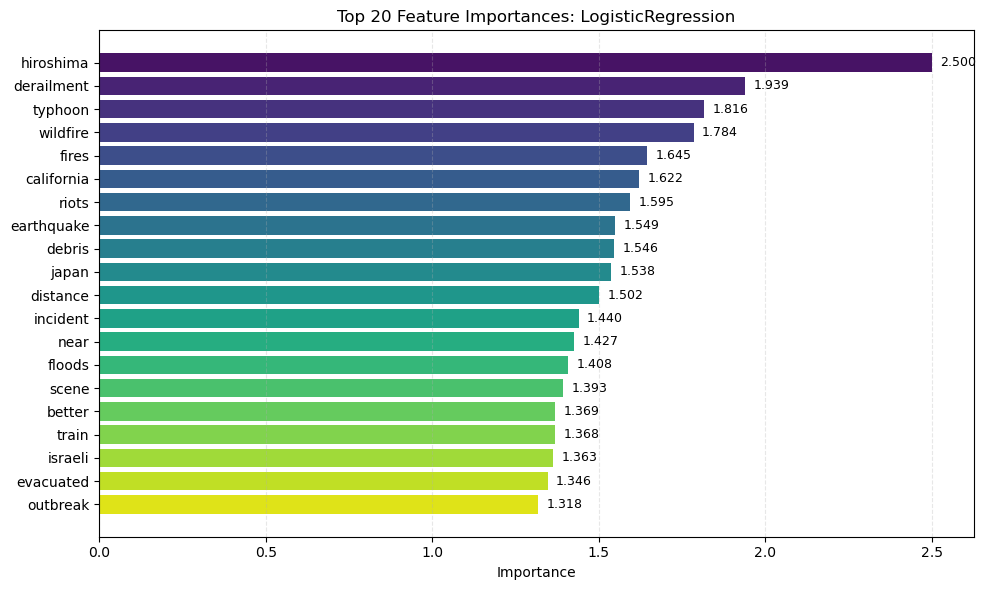

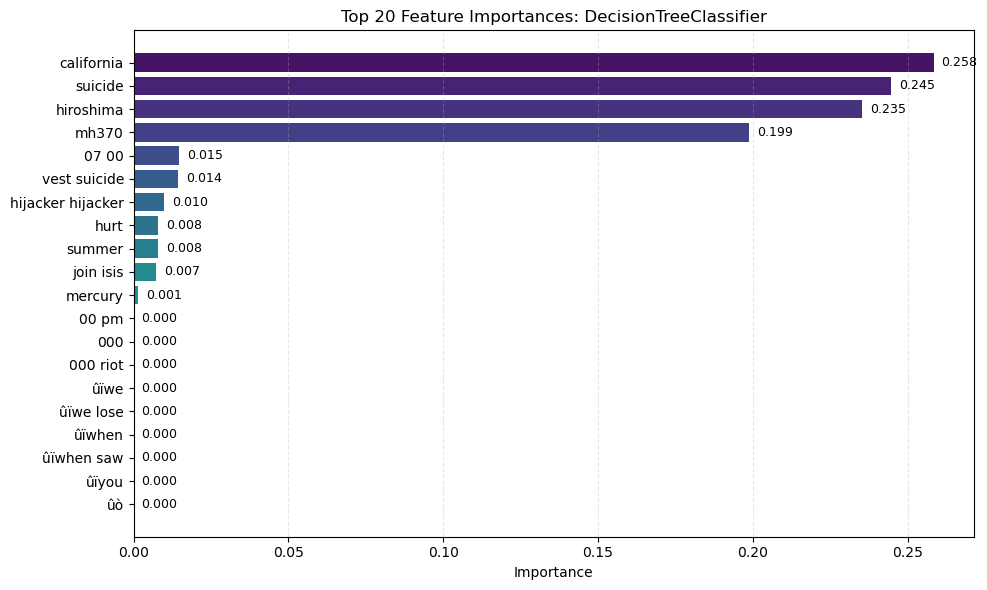

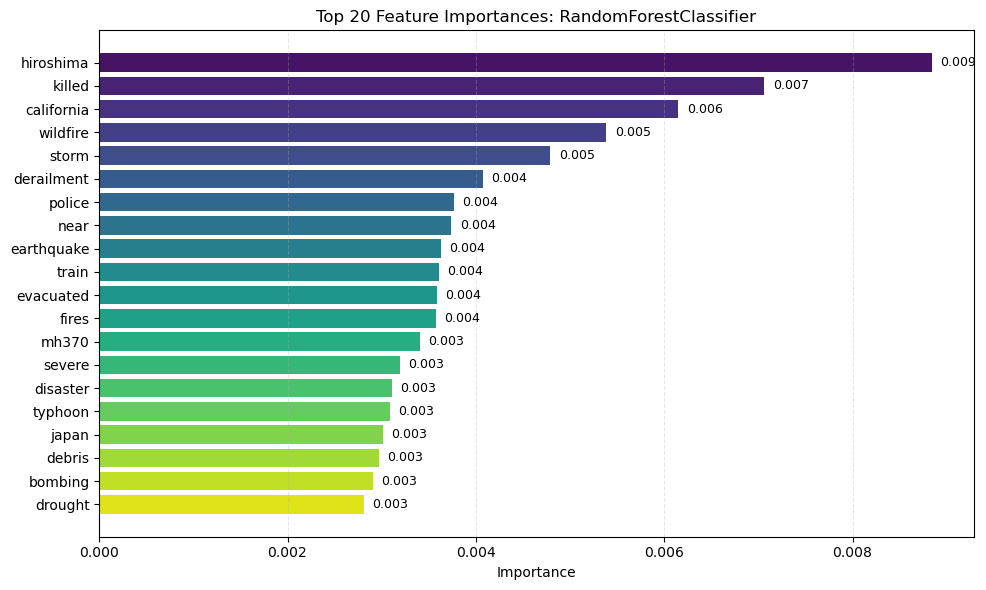

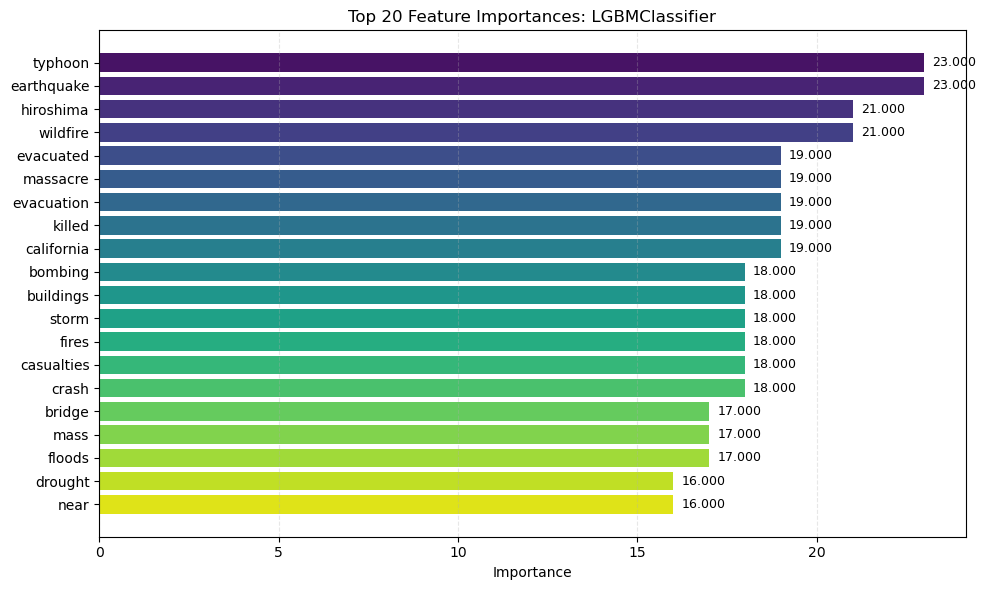

In [20]:
plot_feature_importance_for_models(cv_pipelines_cleaned, top_n=20)

Теперь интерпретируемость моделей гораздо лучше

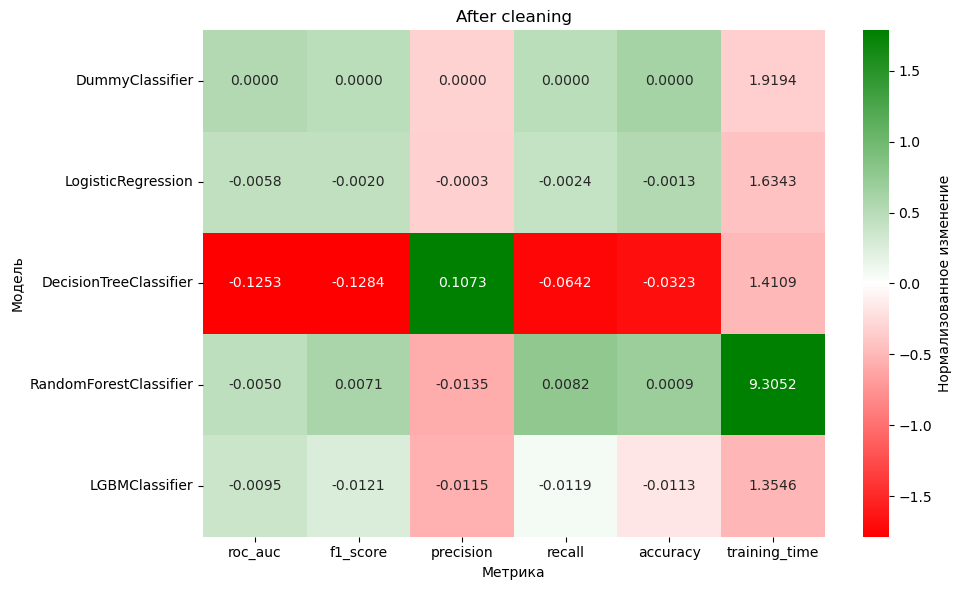

In [22]:
# Сравниваем улучшения
diff_df = compare_models_improvement(
    new_results=cv_results_cleaned,
    base_results=count_vectorizer_results,
    title='After cleaning',
    metrics_to_compare=['roc_auc', 'f1_score', 'precision', 'recall', 'accuracy', 'training_time']
)

Несмотря на то, что модели больше не реагируют на ненужные слова, результат по метрикам почти никакой, они остаются примерно такими же

### 5. CountVectorizer + топ-1000 n-грамм по ANOVA F-value

Теперь попробуем применить отбор признаков на основе ANOVA F-value. Этот тест измеряет насколько сильно каждый отдельный n-грамм коррелирует с целевой переменной

- высокий f-value означает, что средние значения частоты n-граммы значительно различаются между классами (катастрофа vs не катастрофа), т.е. признак информативен для классификации

Отберем топ-1000 наиболее информативных n-грамм после векторизации с CountVectorizer (с удалением стоп-слов и глубокой очистки текста)

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.feature_selection import f_classif

class TopNgramsANOVA(BaseEstimator, TransformerMixin):
    def __init__(self, top=1000):
        self.top = top
        self.selected_idx = None

    def fit(self, X, y):
        f_scores, _ = f_classif(X, y)

        idx = np.argsort(f_scores)[::-1]

        self.selected_idx = idx[:self.top]
        return self

    def transform(self, X):
        return X[:, self.selected_idx]


In [56]:
count_vectorizer_1k_preprocessor = Pipeline([
    ('vectorizer', CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        stop_words='english',
        dtype=np.float32
    )),
    ('anova_top', TopNgramsANOVA(top=1000))
])

                    model   roc_auc  f1_score  precision    recall  accuracy  \
0         DummyClassifier  0.500000  0.363195   0.285170  0.500000  0.570340   
1      LogisticRegression  0.840370  0.771250   0.789295  0.766374  0.782874   
2  DecisionTreeClassifier  0.553463  0.473391   0.780261  0.553916  0.616183   
3  RandomForestClassifier  0.819769  0.757240   0.771113  0.753180  0.768556   
4          LGBMClassifier  0.819565  0.753392   0.770834  0.749147  0.766061   

   training_time  
0       2.348887  
1       1.550631  
2       1.595090  
3       6.971055  
4       2.406142  


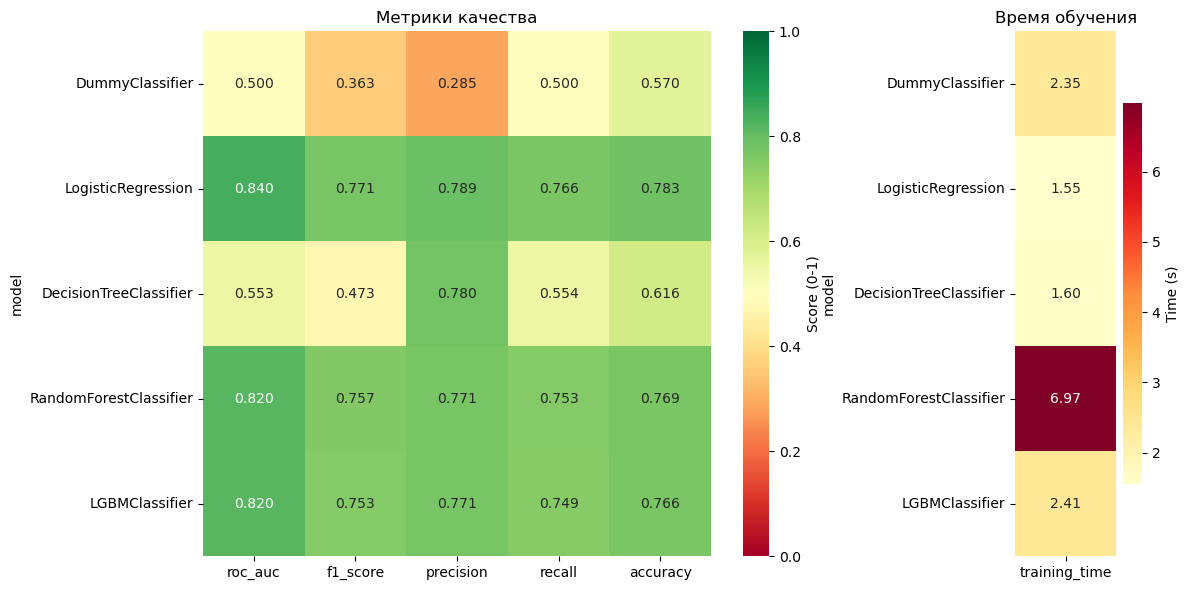

,model,roc_auc,f1_score,precision,recall,accuracy,training_time
0,DummyClassifier,0.500000,0.363195,0.285170,0.500000,0.570340,2.348887
1,LogisticRegression,0.840370,0.771250,0.789295,0.766374,0.782874,1.550631
2,DecisionTreeClassifier,0.553463,0.473391,0.780261,0.553916,0.616183,1.595090
3,RandomForestClassifier,0.819769,0.757240,0.771113,0.753180,0.768556,6.971055
4,LGBMClassifier,0.819565,0.753392,0.770834,0.749147,0.766061,2.406142


In [57]:
cv_results_1k_metrics, cv_pipelines_1k_metrics = train_evaluate_models_cv(
    models=models,
    X=X_text_deep_cleaned,
    y=y,
    preprocessor=count_vectorizer_1k_preprocessor,
    cv=cv,
    seed=SEED
)

compare_models_metrics(cv_results_1k_metrics)


In [53]:
X, y = df['full_text'], df['target']

Отобрано 1000 признаков.

Топ-20 n-грамм по ANOVA F-value:
 1. california
 2. suicide
 3. hiroshima
 4. killed
 5. mh370
 6. northern
 7. wildfire
 8. suicide bomber
 9. bomber
10. bombing
11. fires
12. atomic
13. homes
14. typhoon
15. debris
16. train
17. malaysia
18. body
19. news
20. japan


C:\Users\luckydiss\AppData\Local\Temp\ipykernel_11096\3939392557.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_names, ax=ax, palette="viridis")
C:\Users\luckydiss\AppData\Local\Temp\ipykernel_11096\3939392557.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_names, ax=ax, palette="viridis")
C:\Users\luckydiss\AppData\Local\Temp\ipykernel_11096\3939392557.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_names, ax=ax, palette="viridis")
C:\Users\luckydiss\AppData\Local\T

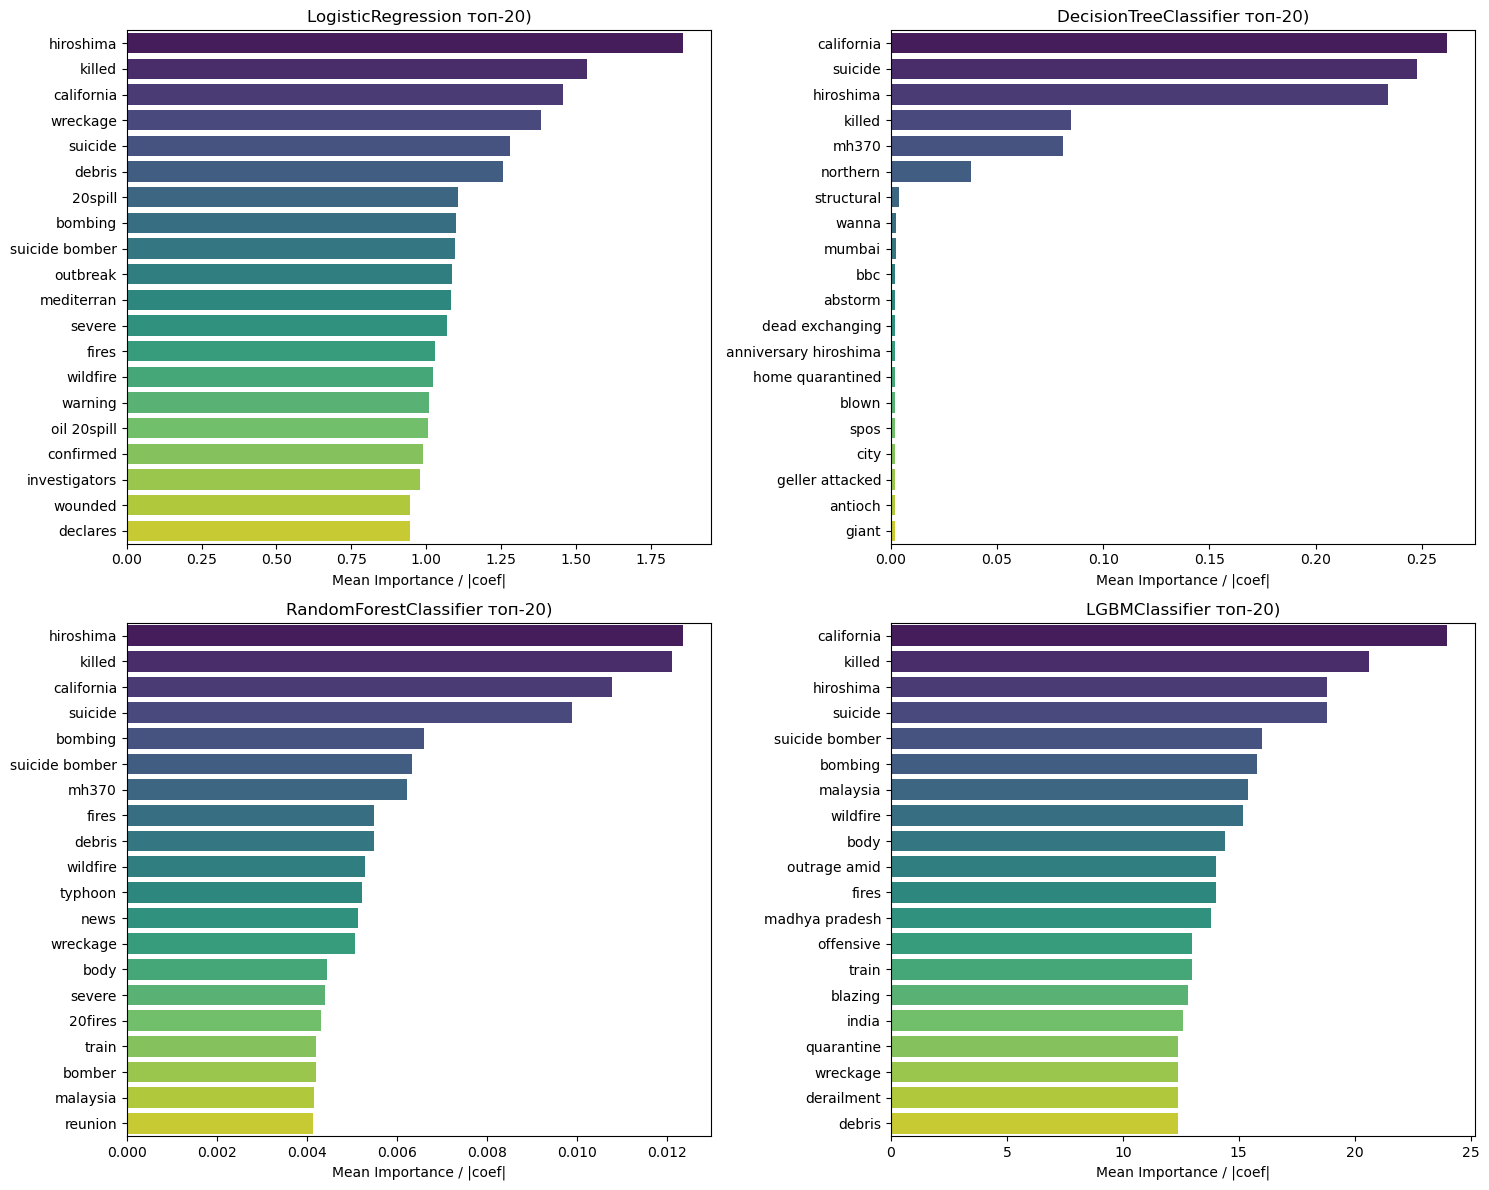

In [59]:

plot_feature_importance_anova_1k(cv_pipelines_1k_metrics, X_text_deep_cleaned, y, cv, top_n=20)

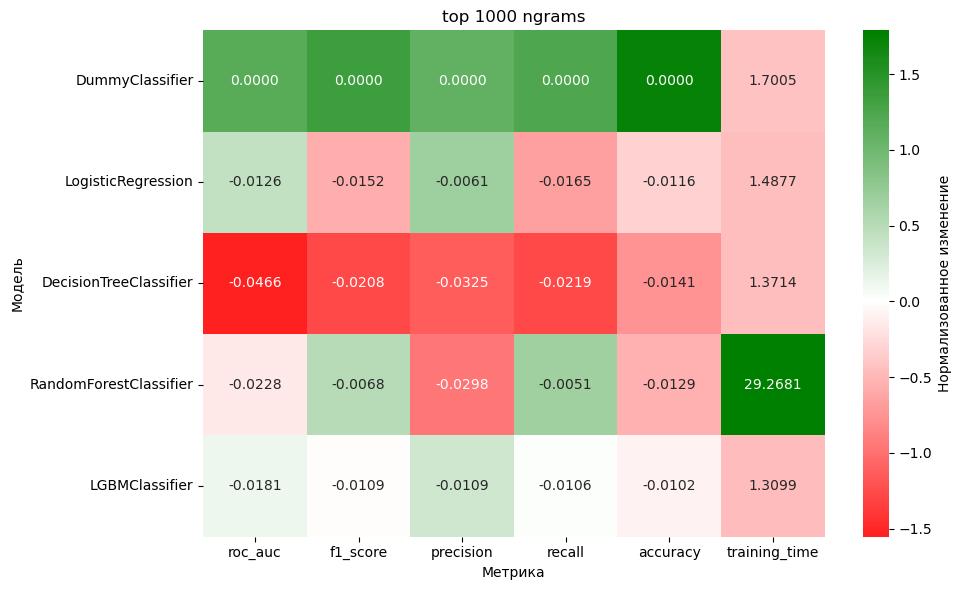

In [36]:
# Сравниваем улучшения
diff_df = compare_models_improvement(
    new_results=cv_results_1k_metrics,
    base_results=count_vectorizer_results,
    title='top 1000 ngrams',
    metrics_to_compare=['roc_auc', 'f1_score', 'precision', 'recall', 'accuracy', 'training_time']
)

Качество моделей упало незначительно , а скорость сильно выросла. Также модели стали еще более интерпретируемыми

### 6. TFIDF 

Переходим к TfidfVectorizer. TF-IDF (Term Frequency — Inverse Document Frequency) снижает вес сверхчастотных токенов, которые встречаются во многих документах, и повышает вес редких, но информативных слов

In [ ]:
X, y = df['full_text'], df['target']

In [69]:
tfidf_preprocessor = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        sublinear_tf=True,
        dtype=np.float32
    ))
])


                    model   roc_auc  f1_score  precision    recall  accuracy  \
0         DummyClassifier  0.500000  0.363195   0.285170  0.500000  0.570340   
1      LogisticRegression  0.862487  0.797546   0.810408  0.792746  0.806253   
2  DecisionTreeClassifier  0.686157  0.638376   0.696730  0.644694  0.678970   
3  RandomForestClassifier  0.834430  0.756373   0.796793  0.751009  0.775122   
4          LGBMClassifier  0.845124  0.774223   0.788686  0.769638  0.784711   

   training_time  
0       0.662992  
1       0.645349  
2       0.824259  
3      30.218237  
4       3.512092  


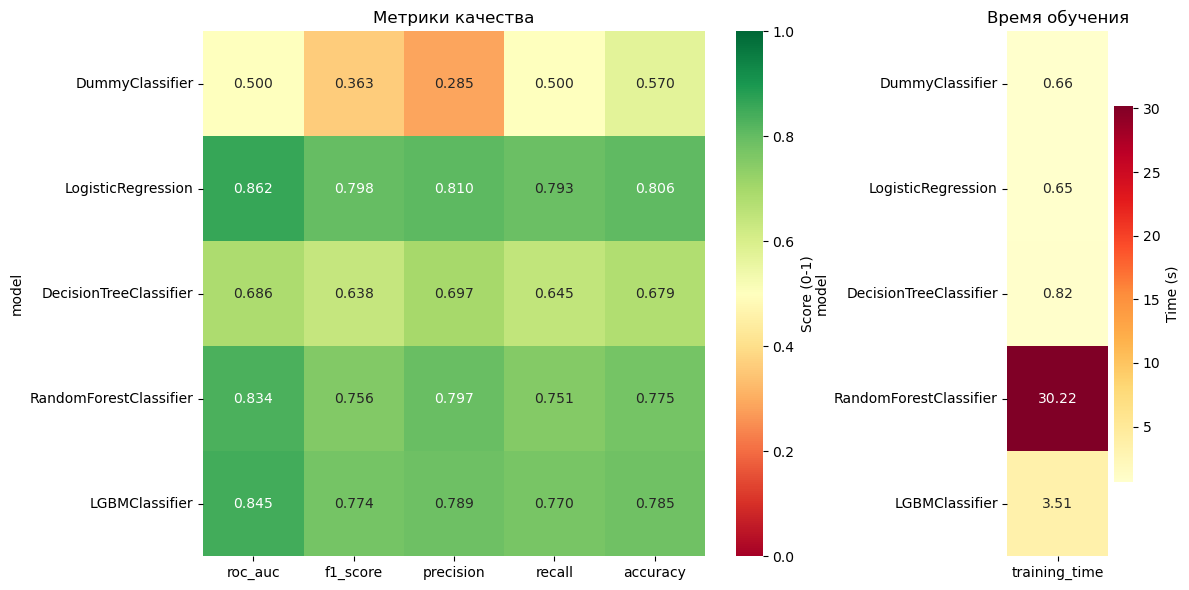

,model,roc_auc,f1_score,precision,recall,accuracy,training_time
0,DummyClassifier,0.500000,0.363195,0.285170,0.500000,0.570340,0.662992
1,LogisticRegression,0.862487,0.797546,0.810408,0.792746,0.806253,0.645349
2,DecisionTreeClassifier,0.686157,0.638376,0.696730,0.644694,0.678970,0.824259
3,RandomForestClassifier,0.834430,0.756373,0.796793,0.751009,0.775122,30.218237
4,LGBMClassifier,0.845124,0.774223,0.788686,0.769638,0.784711,3.512092


In [70]:
tfidf_vectorizer_results, tfidf_pipelines_raw = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=tfidf_preprocessor,
    cv=cv,
    seed=SEED
)

compare_models_metrics(tfidf_vectorizer_results)

[DummyClassifier] does not support feature importance



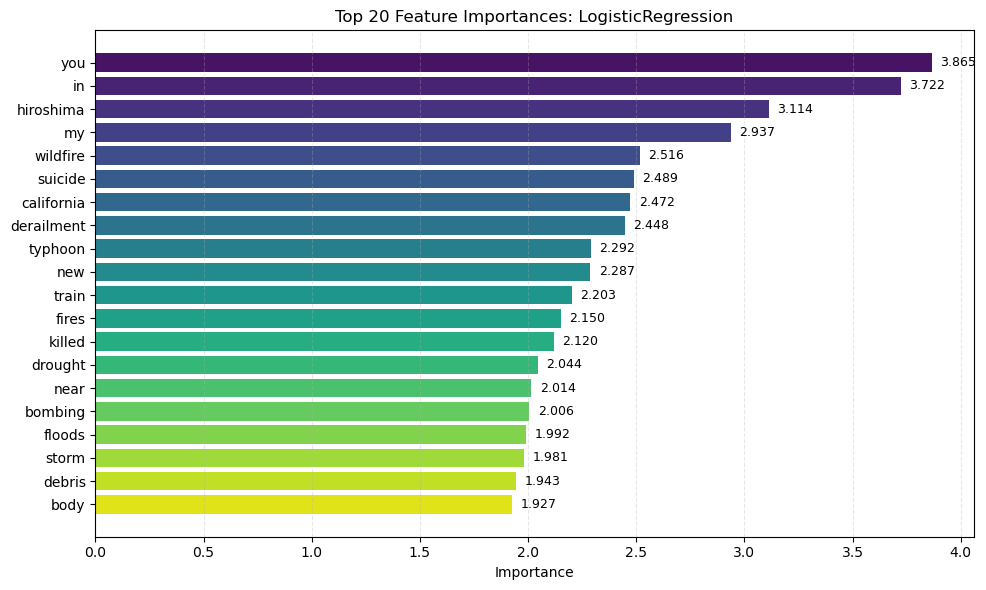

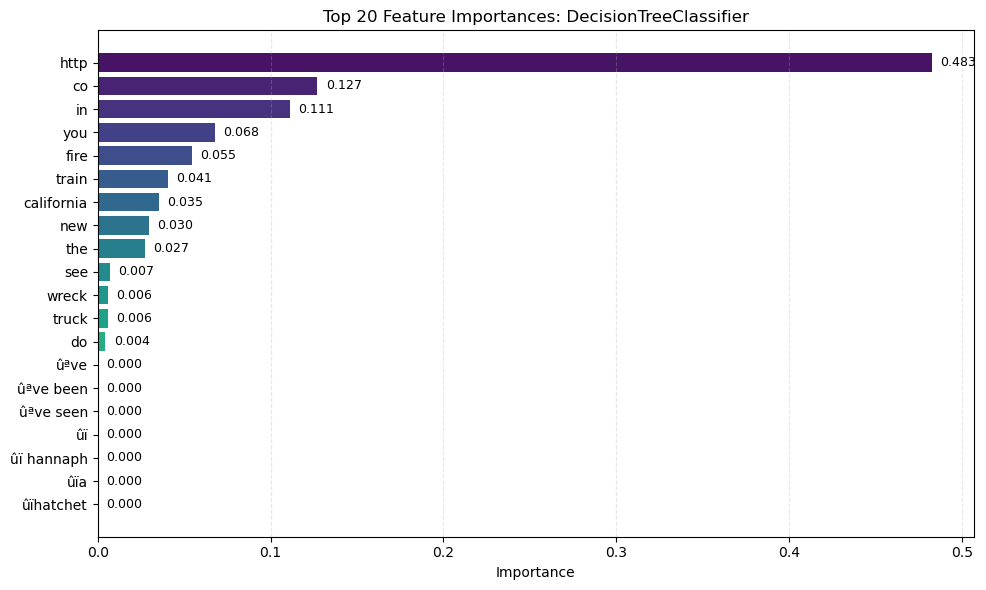

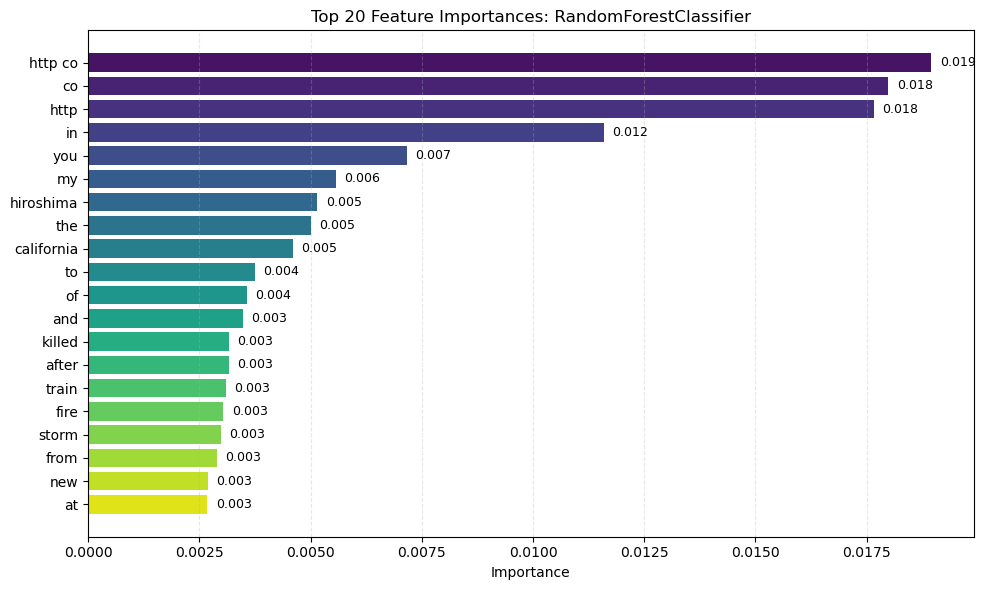

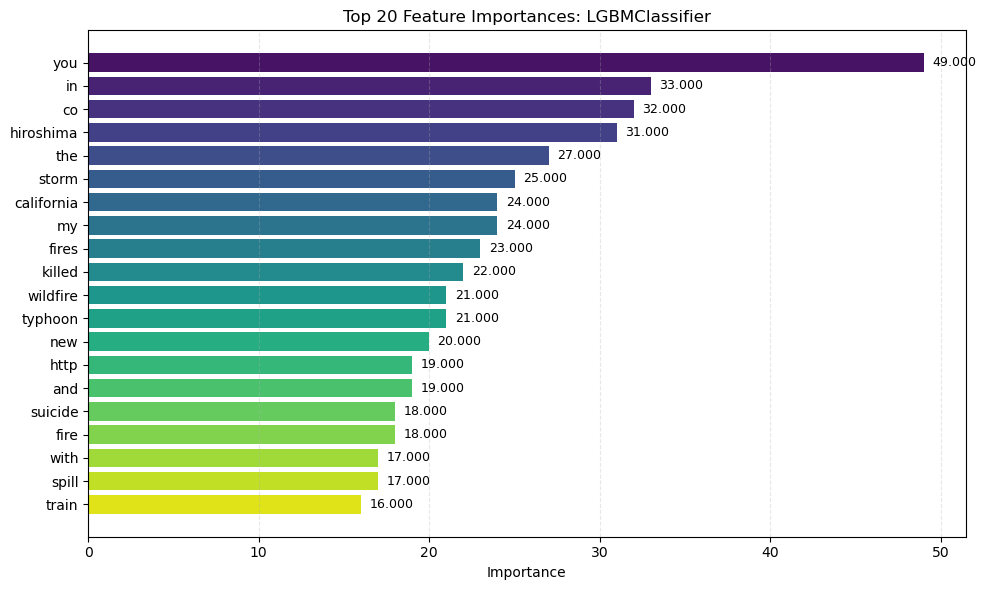

In [71]:
plot_feature_importance_for_models(tfidf_pipelines_raw, top_n=20)

Если сравнить важность признаков с CountVectorizer на чистых данных, имеем следующие различия:

- Logistic Regression в основном также выделяет реальные маркеры катастроф (однако с tfidf важными также оказались некоторые стоп слова)
- Decision Tree также переоценивает признак http и ему подобные
- Random Forest также распределяет важности между артефактами и disaster-терминами, но уже больше в сторону артефактов
- LGBM аналогично тому как было с CountVectorizer учитывет частоту и взаимодействия (you, in - в топе значимых)

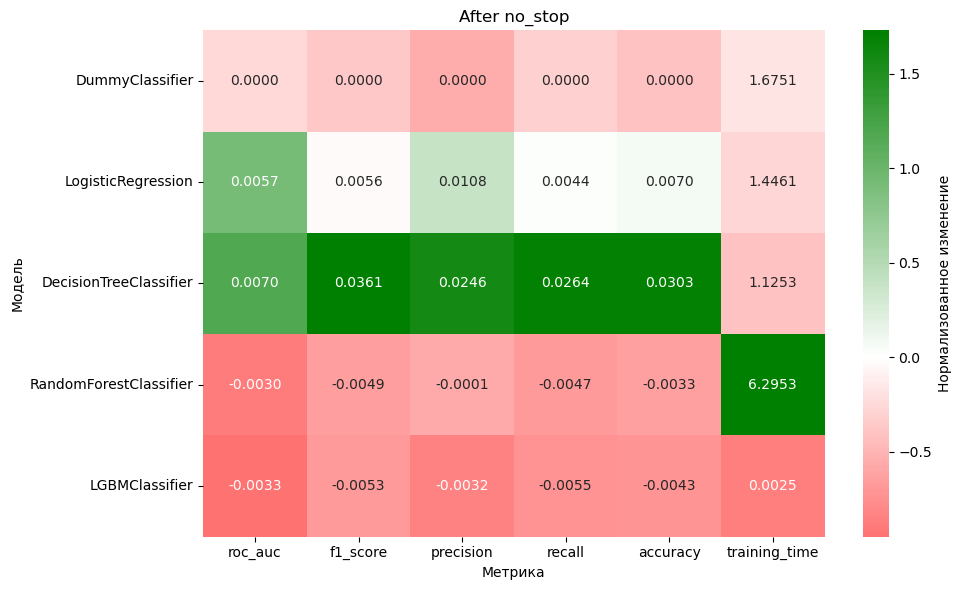

,roc_auc,f1_score,precision,recall,accuracy,training_time
model,,,,,,
DummyClassifier,0.000000,0.000000,0.000000,0.000000,0.000000,1.675101
LogisticRegression,0.005734,0.005640,0.010793,0.004371,0.006963,1.446141
DecisionTreeClassifier,0.007020,0.036107,0.024586,0.026433,0.030343,1.125256
RandomForestClassifier,-0.002989,-0.004917,-0.000055,-0.004727,-0.003283,6.295316
LGBMClassifier,-0.003298,-0.005289,-0.003232,-0.005497,-0.004335,0.002534


In [72]:
compare_models_improvement(
    new_results=tfidf_vectorizer_results,
    base_results=count_vectorizer_results,
    title='After no_stop',
    metrics_to_compare=['roc_auc', 'f1_score', 'precision', 'recall', 'accuracy', 'training_time']
)

TFIDF сработал быстрее, а качество почти не изменилось. Идем дальше

### 7. TFIDF + stop words

In [73]:
tfidf_no_stop_preprocessor = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        stop_words='english',
        sublinear_tf=True,
        dtype=np.float32
    ))
])

                    model   roc_auc  f1_score  precision    recall  accuracy  \
0         DummyClassifier  0.500000  0.363195   0.285170  0.500000  0.570340   
1      LogisticRegression  0.858854  0.793601   0.805767  0.789029  0.802312   
2  DecisionTreeClassifier  0.674561  0.592276   0.688943  0.612554  0.655852   
3  RandomForestClassifier  0.838122  0.770691   0.797542  0.765039  0.784842   
4          LGBMClassifier  0.836701  0.770459   0.786246  0.765821  0.781559   

   training_time  
0       2.214810  
1       2.045587  
2       1.712595  
3      23.334353  
4       3.250602  


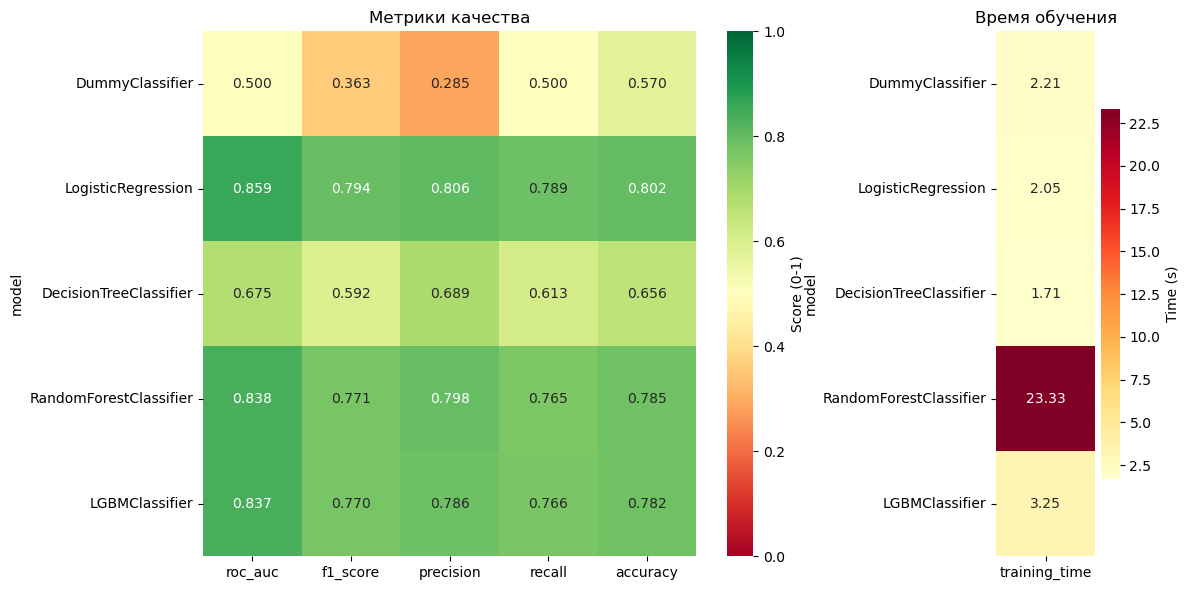

,model,roc_auc,f1_score,precision,recall,accuracy,training_time
0,DummyClassifier,0.500000,0.363195,0.285170,0.500000,0.570340,2.214810
1,LogisticRegression,0.858854,0.793601,0.805767,0.789029,0.802312,2.045587
2,DecisionTreeClassifier,0.674561,0.592276,0.688943,0.612554,0.655852,1.712595
3,RandomForestClassifier,0.838122,0.770691,0.797542,0.765039,0.784842,23.334353
4,LGBMClassifier,0.836701,0.770459,0.786246,0.765821,0.781559,3.250602


In [74]:
tfidf_results_no_stop, tfidf_pipelines_no_stop = train_evaluate_models_cv(
    models=models,
    X=X,
    y=y,
    preprocessor=tfidf_no_stop_preprocessor,
    cv=cv,
    seed=SEED
)

compare_models_metrics(tfidf_results_no_stop)

[DummyClassifier] does not support feature importance



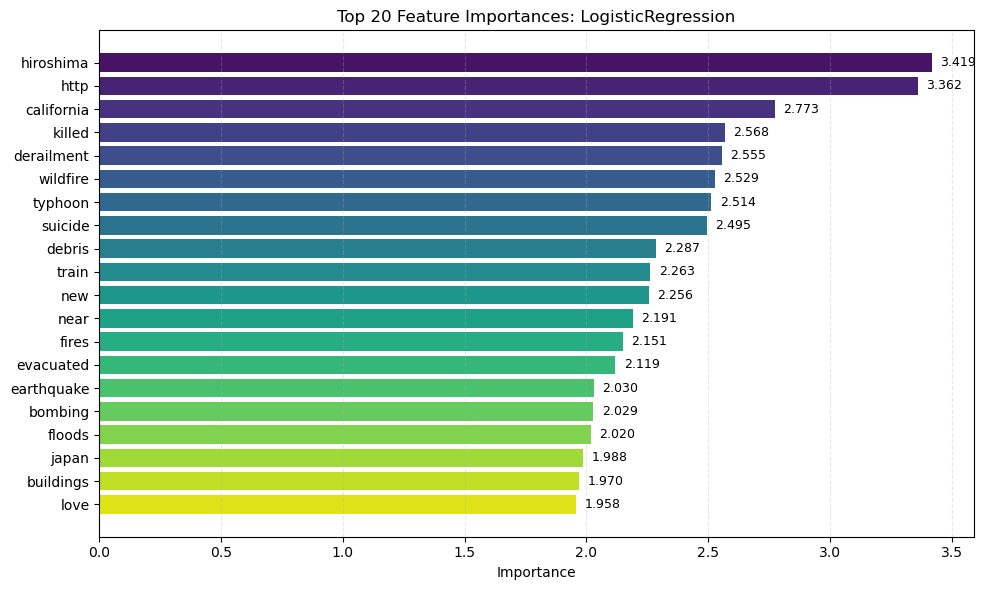

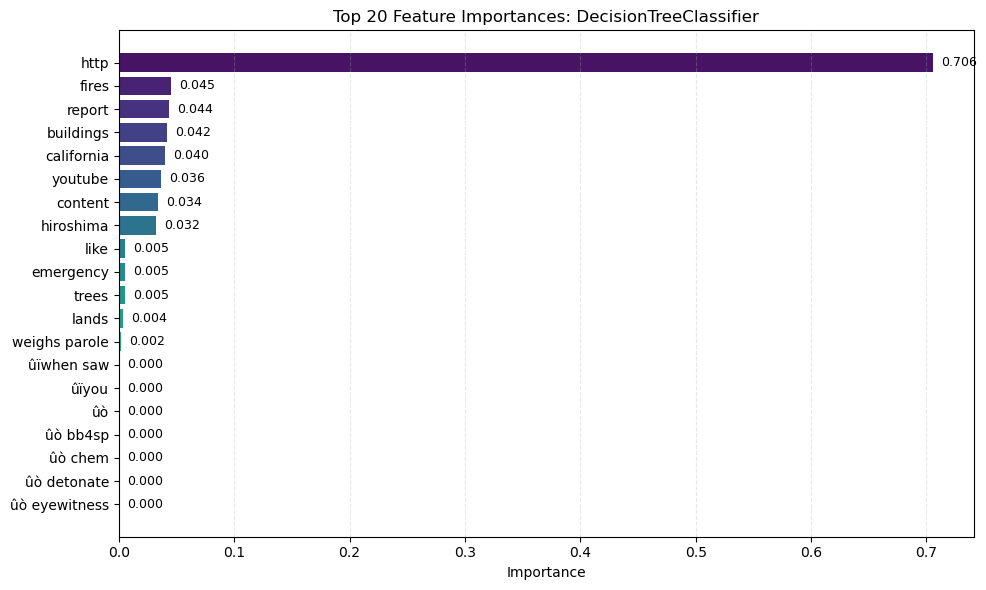

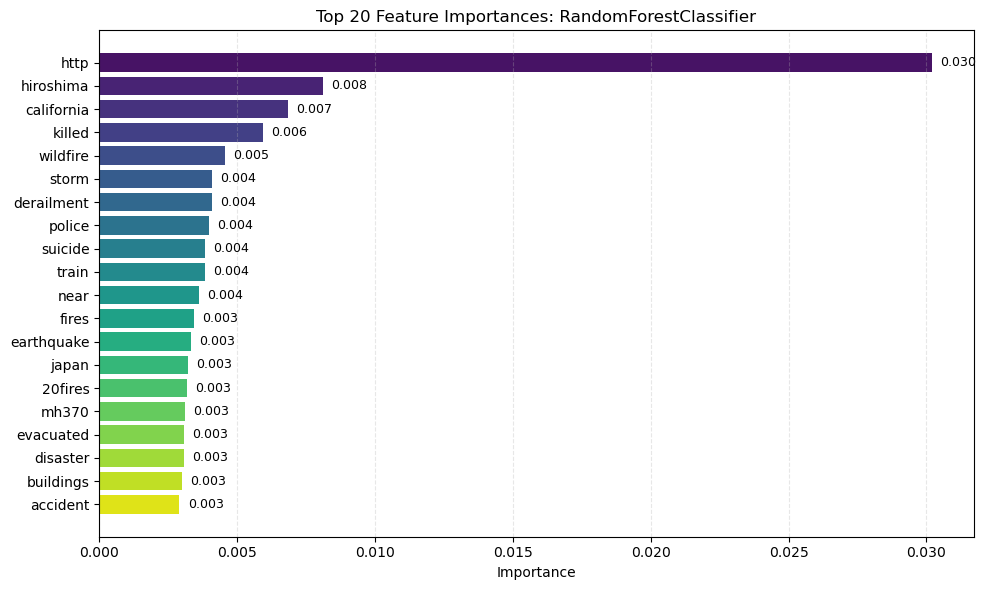

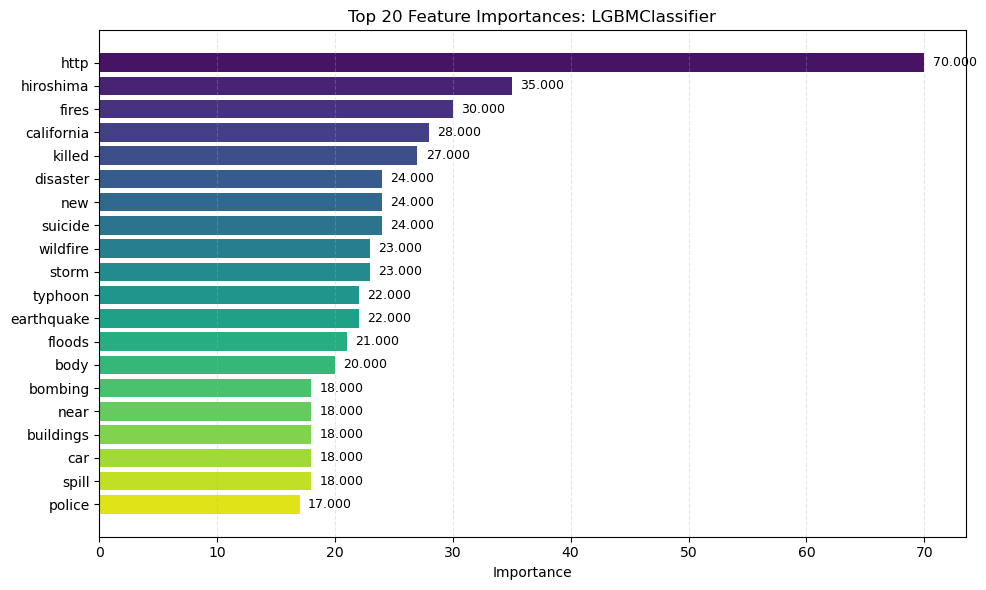

In [75]:
plot_feature_importance_for_models(tfidf_pipelines_no_stop, top_n=20)

Интерпретируемость стала лучше, но все еще присутствуют характерные твитам слова (в основном http)

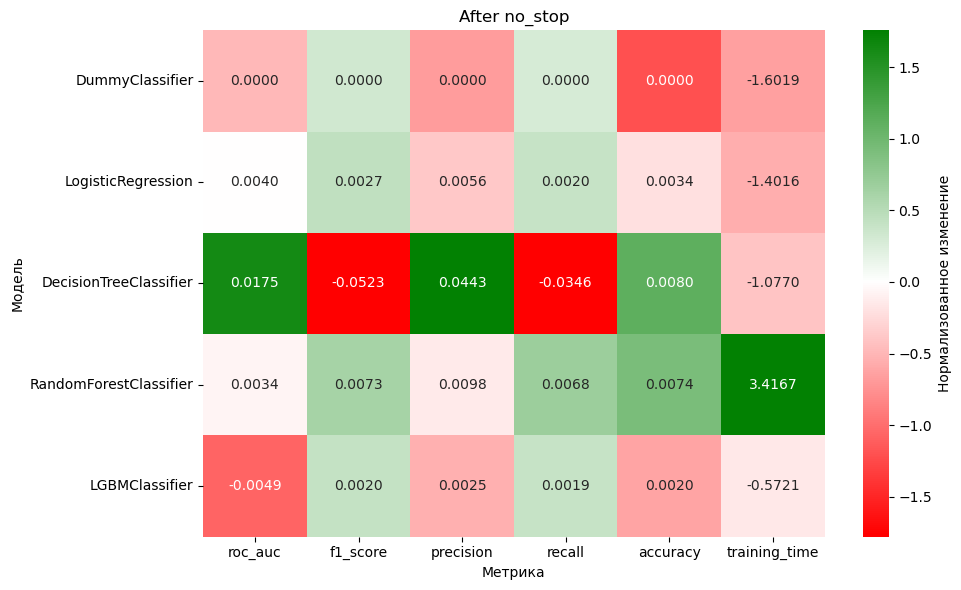

In [76]:
diff_df = compare_models_improvement(
    new_results=tfidf_results_no_stop,
    base_results=cv_results_no_stop,
    title='After no_stop',
    metrics_to_compare=['roc_auc', 'f1_score', 'precision', 'recall', 'accuracy', 'training_time']
)

По сравнением с CountVectorizer (с удалением стоп слов) также не наблюдаем особого улучшения. Идем дальше, попробуем выполнить очистку твитов:

### 8. TFIDF + stop_words + очистка твитов

In [81]:
df['text_cleaned'] = df['full_text'].apply(clean_tweet_text)

X_text_cleaned = df['text_cleaned']


                    model   roc_auc  f1_score  precision    recall  accuracy  \
0         DummyClassifier  0.500000  0.363195   0.285170  0.500000  0.570340   
1      LogisticRegression  0.857199  0.791555   0.804186  0.786929  0.800474   
2  DecisionTreeClassifier  0.552468  0.472188   0.778763  0.553189  0.615526   
3  RandomForestClassifier  0.833917  0.774696   0.788179  0.770248  0.784844   
4          LGBMClassifier  0.836024  0.766916   0.782288  0.762450  0.778013   

   training_time  
0       0.617746  
1       0.501100  
2       0.934180  
3      21.035429  
4       3.826092  


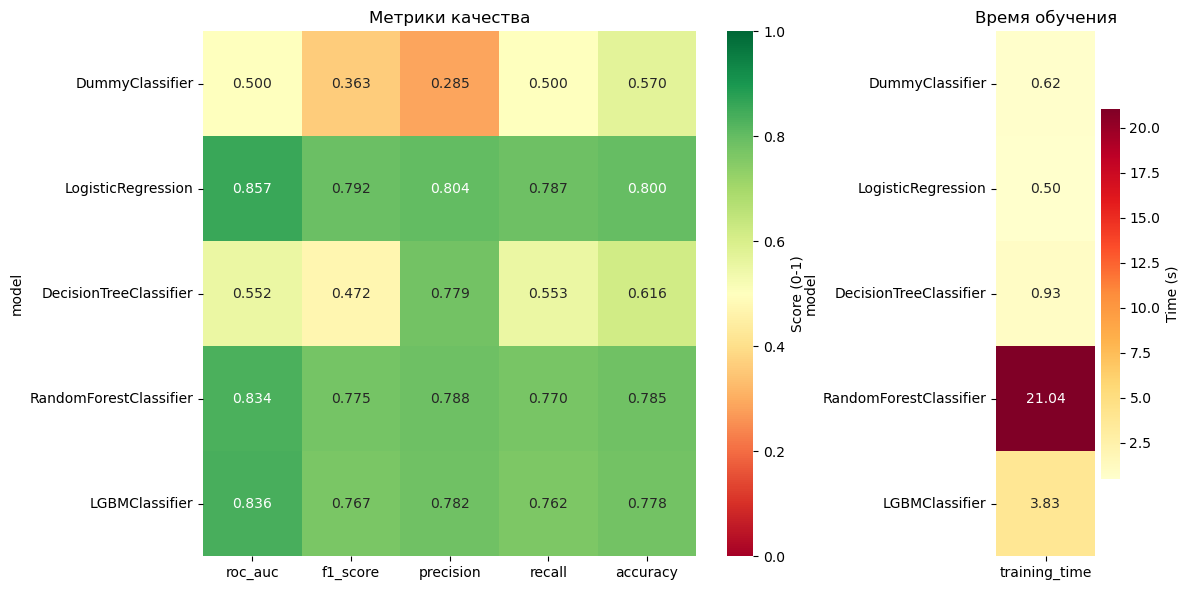

,model,roc_auc,f1_score,precision,recall,accuracy,training_time
0,DummyClassifier,0.500000,0.363195,0.285170,0.500000,0.570340,0.617746
1,LogisticRegression,0.857199,0.791555,0.804186,0.786929,0.800474,0.501100
2,DecisionTreeClassifier,0.552468,0.472188,0.778763,0.553189,0.615526,0.934180
3,RandomForestClassifier,0.833917,0.774696,0.788179,0.770248,0.784844,21.035429
4,LGBMClassifier,0.836024,0.766916,0.782288,0.762450,0.778013,3.826092


In [85]:
tfidf_vectorizer_cleaned = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.85,
        stop_words = 'english',
        sublinear_tf=True,
        dtype=np.float32
    ))
])

tfidf_results_cleaned, tfidf_pipelines_cleaned = train_evaluate_models_cv(
    models=models,
    X=X_text_cleaned,
    y=y,
    preprocessor=tfidf_vectorizer_cleaned,
    cv=cv,
    seed=SEED
)

compare_models_metrics(tfidf_results_cleaned)

[DummyClassifier] does not support feature importance



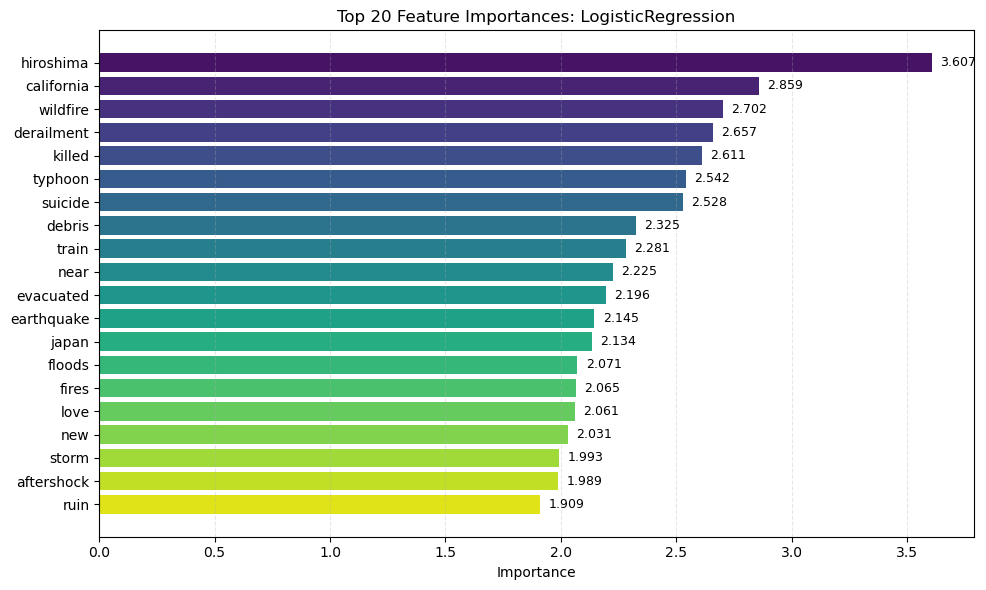

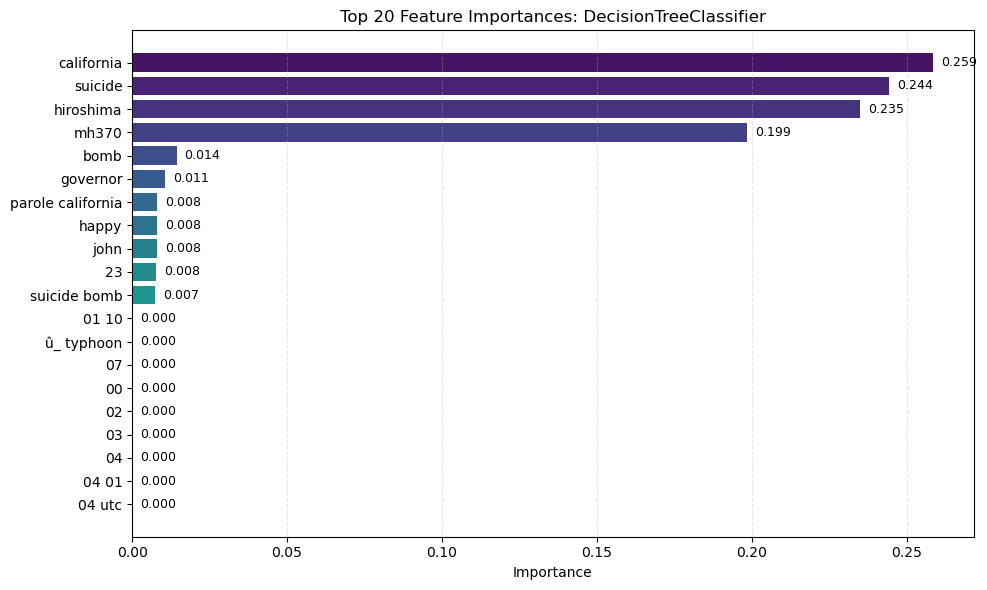

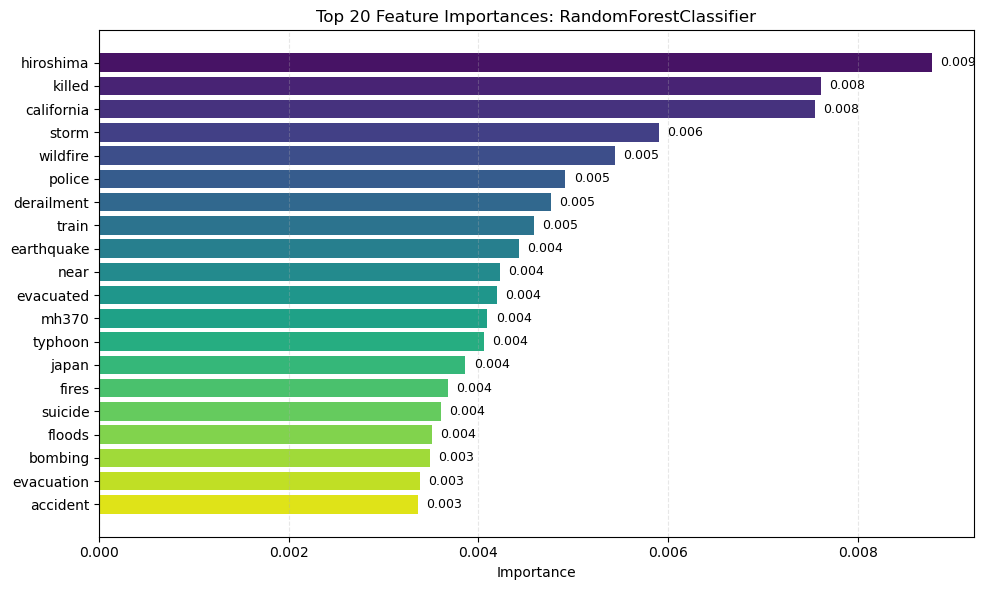

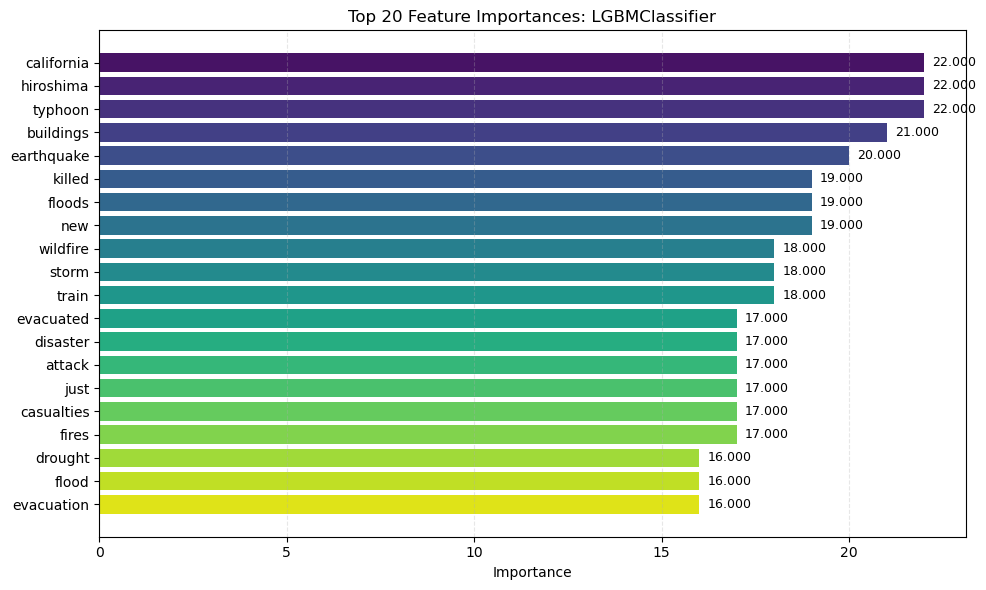

In [86]:
plot_feature_importance_for_models(tfidf_pipelines_cleaned, top_n=20)

Теперь модели получились более интерпретируемы

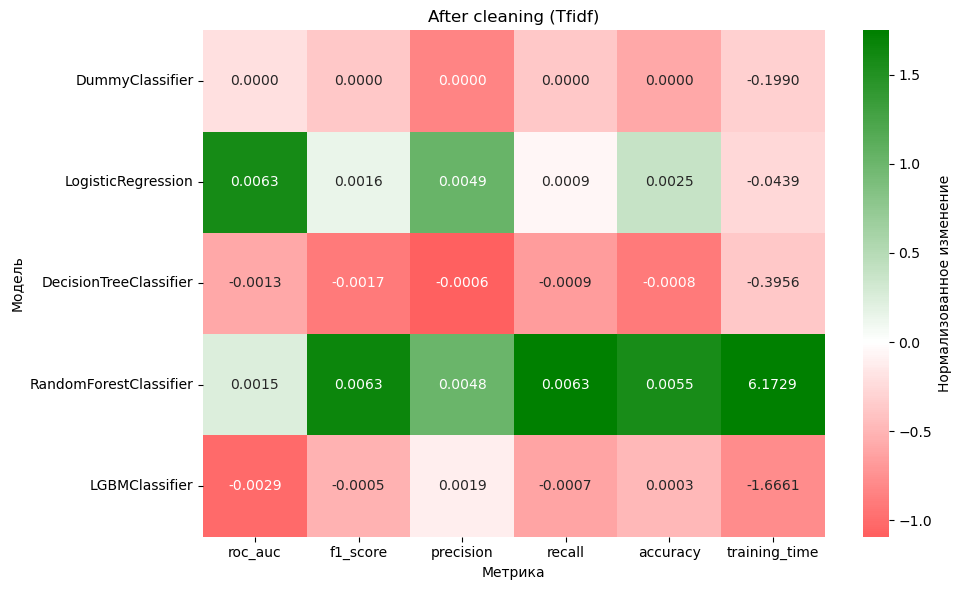

In [87]:
diff_df = compare_models_improvement(
    new_results=tfidf_results_cleaned,
    base_results=cv_results_cleaned,
    title='After cleaning (Tfidf)',
    metrics_to_compare=['roc_auc', 'f1_score', 'precision', 'recall', 'accuracy', 'training_time']
)

Особого прироста метрик не наблюдается, однако улучшилось время для random forest

### 5. TF IDF + топ-1000 n-грамм по ANOVA F-value

Попробуем по аналогии подхода с CountVectorizer отобрать только значимые признаки:

In [89]:
tfidf_1k_preprocessor = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9,
        stop_words='english',
        sublinear_tf=True,
        dtype=np.float32
    )),
    ('anova_top', TopNgramsANOVA(top=1000))
])

                    model   roc_auc  f1_score  precision    recall  accuracy  \
0         DummyClassifier  0.500000  0.363195   0.285170  0.500000  0.570340   
1      LogisticRegression  0.835696  0.759832   0.784894  0.754819  0.774336   
2  DecisionTreeClassifier  0.554066  0.473943   0.780416  0.554221  0.616446   
3  RandomForestClassifier  0.810382  0.745457   0.753720  0.742416  0.755289   
4          LGBMClassifier  0.817348  0.745876   0.767122  0.741593  0.760412   

   training_time  
0       2.381066  
1       1.531296  
2       1.576382  
3       6.874630  
4       2.570708  


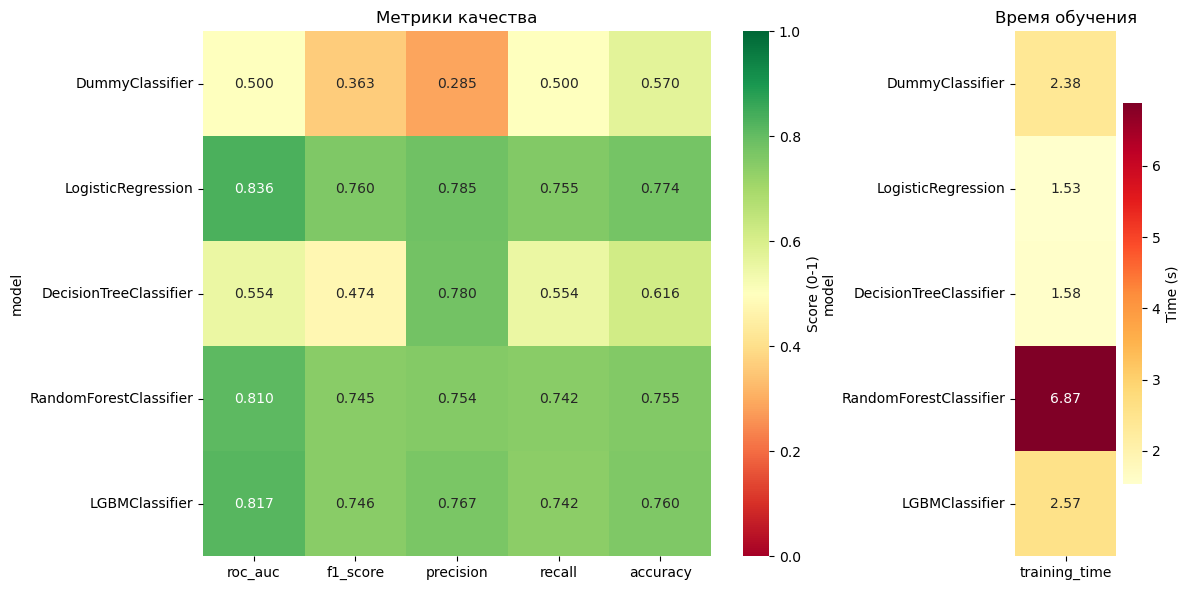

,model,roc_auc,f1_score,precision,recall,accuracy,training_time
0,DummyClassifier,0.500000,0.363195,0.285170,0.500000,0.570340,2.381066
1,LogisticRegression,0.835696,0.759832,0.784894,0.754819,0.774336,1.531296
2,DecisionTreeClassifier,0.554066,0.473943,0.780416,0.554221,0.616446,1.576382
3,RandomForestClassifier,0.810382,0.745457,0.753720,0.742416,0.755289,6.874630
4,LGBMClassifier,0.817348,0.745876,0.767122,0.741593,0.760412,2.570708


In [90]:
tfidf_results_1k_metrics, tfidf_pipelines_1k_metrics = train_evaluate_models_cv(
    models=models,
    X=X_text_deep_cleaned,
    y=y,
    preprocessor=tfidf_1k_preprocessor,
    cv=cv,
    seed=SEED
)

compare_models_metrics(tfidf_results_1k_metrics)


Отобрано 1000 признаков.

Топ-20 n-грамм по ANOVA F-value:
 1. california
 2. hiroshima
 3. suicide
 4. killed
 5. mh370
 6. northern
 7. suicide bomber
 8. bomber
 9. fires
10. wildfire
11. bombing
12. atomic
13. homes
14. debris
15. malaysia
16. typhoon
17. japan
18. 20fires
19. severe
20. train


C:\Users\luckydiss\AppData\Local\Temp\ipykernel_11096\791290854.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_names, ax=ax, palette="viridis")
C:\Users\luckydiss\AppData\Local\Temp\ipykernel_11096\791290854.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_names, ax=ax, palette="viridis")
C:\Users\luckydiss\AppData\Local\Temp\ipykernel_11096\791290854.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values, y=top_names, ax=ax, palette="viridis")
C:\Users\luckydiss\AppData\Local\Temp

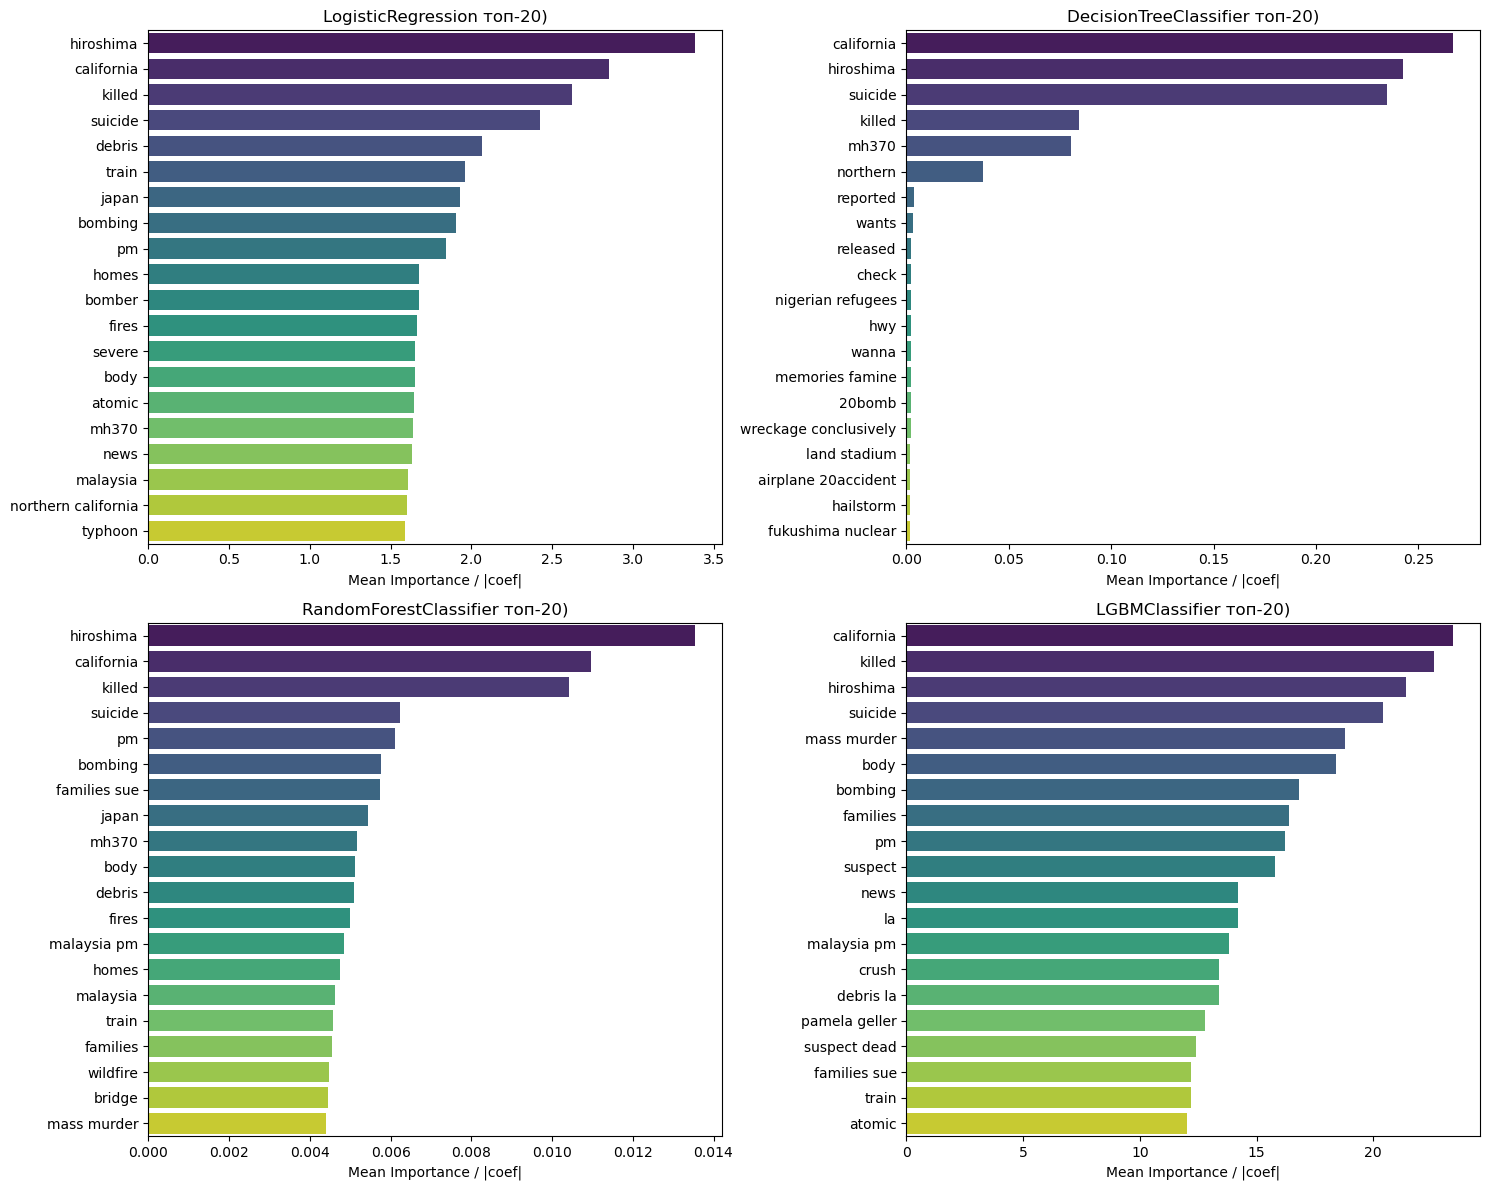

In [93]:

plot_feature_importance_anova_1k(tfidf_pipelines_1k_metrics, X_text_deep_cleaned, y, cv, top_n=20)

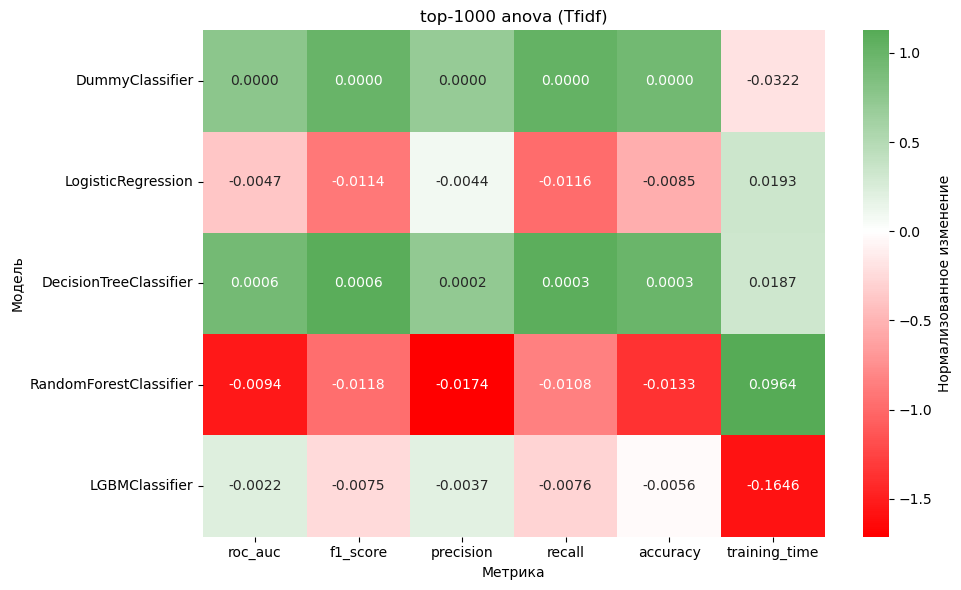

In [94]:
diff_df = compare_models_improvement(
    new_results=tfidf_results_1k_metrics,
    base_results=cv_results_1k_metrics,
    title='top-1000 anova (Tfidf)',
    metrics_to_compare=['roc_auc', 'f1_score', 'precision', 'recall', 'accuracy', 'training_time']
)

Если сравнить с метриками топ 1000 признаков CountVectorizer,то с TFIDF они только ухудшились


Метрики качества приведены для лог. регрессии (т.к. она показывает наиболее стабильный результат).

Метрики времени приведены для самой быстрой (LogReg) и самой медленной (RandomForest) модели

| Подход | ROC AUC | F1 Score | Precision | Recall | Time (LogReg) | Time (RF) |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: |
| 1. Baseline** (CountVectorizer) | 0.8568 | 0.7919 | 0.7996 | 0.7884 | 2.09 s | 36.51 s |
| 2. CV + No Stop Words | 0.8549 | 0.7909 | 0.8002 | 0.7870 | 0.64 s | 26.75 s |
| 3. CV + Deep Cleaning | 0.8509 | 0.7899 | 0.7993 | 0.7860 | **0.46 s** | 27.21 s |
| 4. CV + Top-1000 ANOVA | 0.8404 | 0.7713 | 0.7893 | 0.7664 | 1.55 s | 6.97 s |
| 5. TF-IDF Raw** (Сырые данные) | **0.8625** | **0.7975** | **0.8104** | **0.7927** | 0.65 s | 30.22 s |
| 6. TF-IDF + Stop Words | 0.8589 | 0.7936 | 0.8058 | 0.7890 | 2.05 s | 23.33 s |
| 7. TF-IDF + Deep Cleaning | 0.8572 | 0.7916 | 0.8042 | 0.7869 | 0.50 s | 21.04 s |
| 8. TF-IDF + Top-1000 ANOVA | 0.8357 | 0.7598 | 0.7849 | 0.7548 | 1.53 s | **6.87 s** |

#### Выводы

- TF-IDF Raw (№5) побеждает по всем 4 метрикам качества. Удаление стоп-слов и ссылок снизило метрики, т.к. модель потеряла часть контекста
- TF-IDF + ANOVA (№8) *СV + ANOVA (№4) позволили ускорить обучение в 5 раз по сравнению с базовым TF-IDF.
- Глубокая очистка твитов позволило логистической регрессии обучиться за полсекунды